In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
import itertools
import pickle

2025-01-07 16:08:29.633596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 16:08:29.690500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 16:08:30.274394: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 16:08:30.502847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736266110.733446  202268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736266110.78

In [3]:
# load data
data = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])
data

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1307011,2013-07-01,148.828353,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1307021,2013-07-02,159.793757,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1307031,2013-07-03,111.885594,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1307041,2013-07-04,168.864941,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1307051,2013-07-05,171.280754,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1712216,2017-12-21,87.471228,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9330,1712226,2017-12-22,71.911652,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9331,1712236,2017-12-23,84.062223,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9332,1712246,2017-12-24,60.981969,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# split data to train and validation set
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] > '2017-07-31') & (data['Datum'] <= '2018-08-31')]

# features 
features = [
    'KielerWoche', 'weekend_or_holiday', 
    'wetter_regen','wetter_schnee', 'wetter_gewitter', 'wetter_dunst', 'wetter_nebel',
    'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm', 
    'wind_bin_windstill', 'wind_bin_moderat', 'wind_bin_sturm', 'cloud_Bin_sonnig', 'cloud_Bin_moderat','cloud_Bin_bedeckt',
    'is_silvester',
    'Monat_April', 'Monat_August', 'Monat_December', 'Monat_February',
    'Monat_January', 'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
    'Monat_November', 'Monat_October', 'Monat_September',
    'Warengruppe_Broetchen', 'Warengruppe_Brot', 'Warengruppe_Croissant', 'Warengruppe_Konditorei',
    'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 
    'inflation', 
    'is_Montag', 'is_Dienstag','is_Mittwoch', 'is_Donnerstag', 'is_Freitag', 'is_Samstag'
]

# target (Umsatz)
target = 'Umsatz'

# scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
val_scaled = scaler.transform(val_data[features])

# rename feature and target
x_train = train_scaled
y_train = train_data[target]

x_val = val_scaled
y_val = val_data[target]

## Versuch systematisch die Anzahl der Neuronen in den einzelnen Layers zu variieren
### Versuch 1: 3 und 4 Layers mit Neuronenanzahl von 16 - 32 - 64 - 128
Kernel stirbt nach einigen Modellen

16 - 64 - 16
oder
16 - 128 -16
waren bisher am vielversprechendsten

Training with 3 layers and neurons (16, 16, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-07 15:15:56.907245: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4967.9150 - mae: 211.2132 - val_loss: 4574.0688 - val_mae: 195.4560
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4961.5332 - mae: 210.9563 - val_loss: 4529.4736 - val_mae: 193.6703
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4849.6440 - mae: 206.4807 - val_loss: 4467.3784 - val_mae: 191.1845
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4808.1982 - mae: 204.8164 - val_loss: 4380.2954 - val_mae: 187.7002
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4701.2969 - mae: 200.5355 - val_loss: 4262.7695 - val_mae: 182.9926
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4594.5156 - mae: 196.2537 - val_loss: 4133.9058 - val_mae: 177.8224
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4501.7471 - mae: 192.5156 - val_loss: 3978.6160 - val_mae: 171.5862
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4332.5454 - mae: 185.7210 - val_loss: 3829.5974 

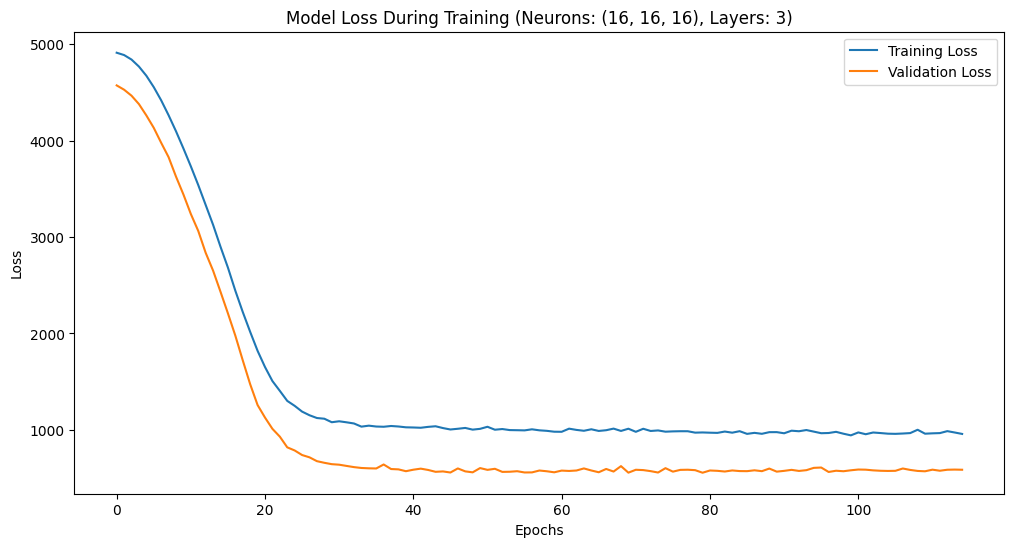

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
MAPE on the Training Data: 17.45%
MAPE für Brot: 18.28%
MAPE für Broetchen: 12.29%
MAPE für Croissant: 17.15%
MAPE für Konditorei: 20.89%
MAPE für Kuchen: 13.01%
MAPE für Saisonbrot: 53.16%

MAPE on the Validation Data: 19.38%
MAPE für Brot: 19.65%
MAPE für Broetchen: 12.31%
MAPE für Croissant: 18.45%
MAPE für Konditorei: 23.61%
MAPE für Kuchen: 15.89%
MAPE für Saisonbrot: 63.96%
Training with 3 layers and neurons (16, 16, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4953.2793 - mae: 210.6271 - val_loss: 4554.2349 - val_mae: 194.6622
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4874.3335 - mae: 207.4666 - val_loss: 4500.8105 - val_mae: 192.5232
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4830.9067 - mae: 205.7284 - val_loss: 4387.5366 - val_mae: 187.9874
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4703.0664 - mae: 200.6072 - val_loss: 4229.2544 - val_mae: 181.6488
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4487.6333 - mae: 191.9622 - val_loss: 4030.9702 - val_mae: 173.6901
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4350.2705 - mae: 186.4256 - val_loss: 3789.2405 - val_mae: 163.9447
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4070.6853 - mae: 175.1376 - val_loss: 3516.9675 - val_mae: 152.8714
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3746.5979 - mae: 161.9667 - val_loss: 3243.1294 

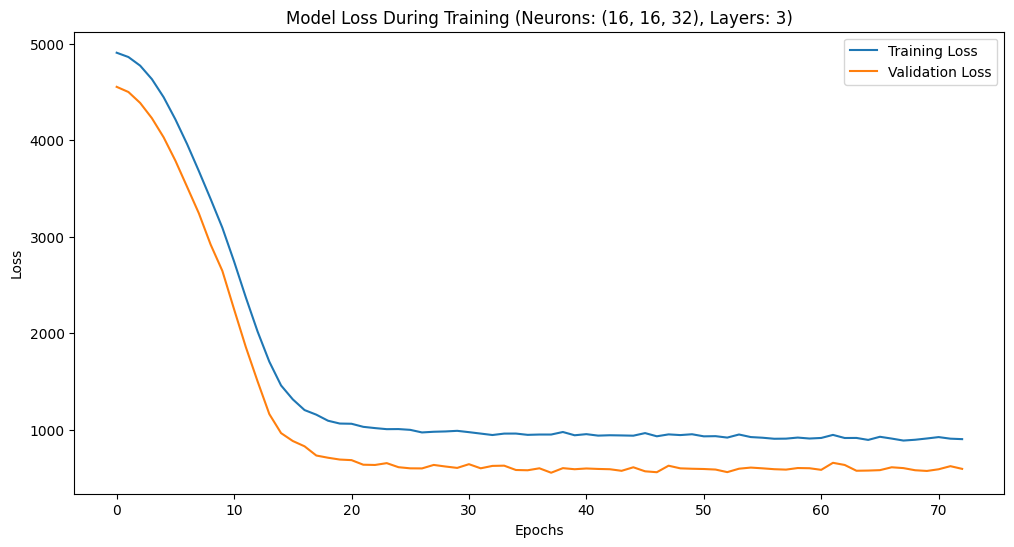

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
MAPE on the Training Data: 19.56%
MAPE für Brot: 22.53%
MAPE für Broetchen: 13.82%
MAPE für Croissant: 18.51%
MAPE für Konditorei: 23.93%
MAPE für Kuchen: 13.57%
MAPE für Saisonbrot: 54.24%

MAPE on the Validation Data: 19.56%
MAPE für Brot: 22.37%
MAPE für Broetchen: 12.57%
MAPE für Croissant: 18.30%
MAPE für Konditorei: 23.92%
MAPE für Kuchen: 14.87%
MAPE für Saisonbrot: 56.52%
Training with 3 layers and neurons (16, 16, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4892.8511 - mae: 208.2097 - val_loss: 4560.9517 - val_mae: 194.9310
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4876.3569 - mae: 207.5480 - val_loss: 4440.4907 - val_mae: 190.1082
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4787.9839 - mae: 204.0012 - val_loss: 4208.1899 - val_mae: 180.8050
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4421.6572 - mae: 189.3205 - val_loss: 3874.6602 - val_mae: 167.3623
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4088.8679 - mae: 175.9060 - val_loss: 3500.7502 - val_mae: 152.2472
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3692.8184 - mae: 159.7943 - val_loss: 3162.9189 - val_mae: 138.6670
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3312.2705 - mae: 144.3347 - val_loss: 2555.0400 - val_mae: 114.2854
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2659.8535 - mae: 118.1140 - val_loss: 1821.3107 

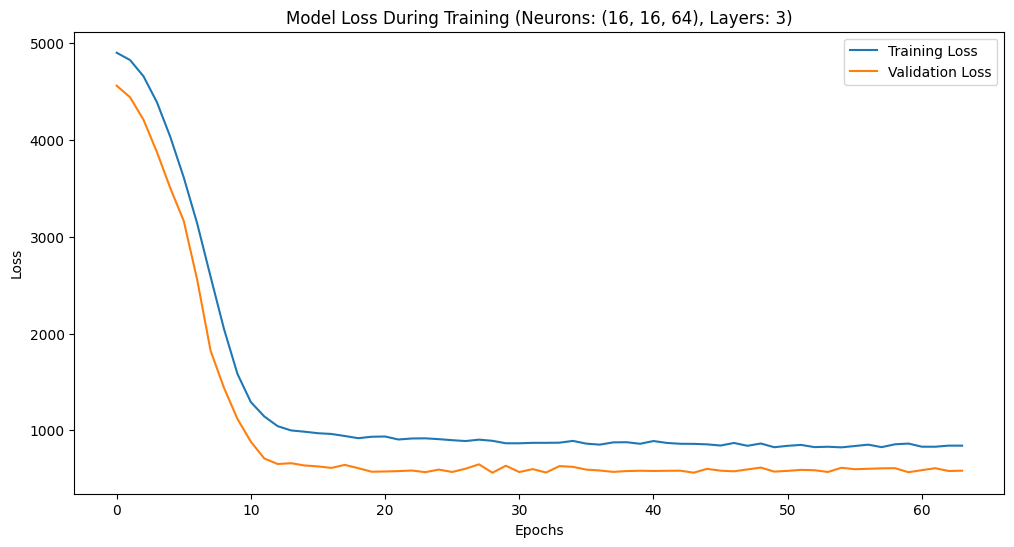

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
MAPE on the Training Data: 19.22%
MAPE für Brot: 21.08%
MAPE für Broetchen: 12.83%
MAPE für Croissant: 18.74%
MAPE für Konditorei: 23.86%
MAPE für Kuchen: 13.67%
MAPE für Saisonbrot: 56.96%

MAPE on the Validation Data: 20.24%
MAPE für Brot: 21.33%
MAPE für Broetchen: 14.02%
MAPE für Croissant: 20.70%
MAPE für Konditorei: 23.34%
MAPE für Kuchen: 14.80%
MAPE für Saisonbrot: 64.84%
Training with 3 layers and neurons (16, 16, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4892.9395 - mae: 208.2130 - val_loss: 4527.8501 - val_mae: 193.6056
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4789.3623 - mae: 204.0665 - val_loss: 4304.0625 - val_mae: 184.6461
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4475.5464 - mae: 191.4896 - val_loss: 3863.6719 - val_mae: 166.9614
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4042.2112 - mae: 173.9983 - val_loss: 3276.7988 - val_mae: 143.1545
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3454.4998 - mae: 150.0592 - val_loss: 2477.9285 - val_mae: 111.0083
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2726.2124 - mae: 120.8324 - val_loss: 1474.7946 - val_mae: 70.5880
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1829.8000 - mae: 84.6360 - val_loss: 938.1872 - val_mae: 48.4128
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1307.6017 - mae: 63.3017 - val_loss: 736.1170 - val_

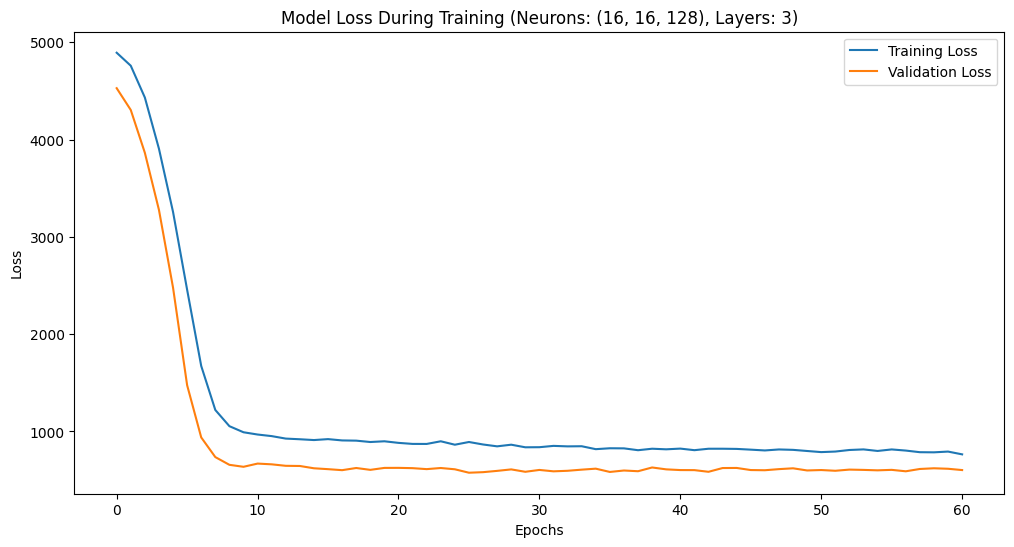

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
MAPE on the Training Data: 21.37%
MAPE für Brot: 22.80%
MAPE für Broetchen: 12.90%
MAPE für Croissant: 19.36%
MAPE für Konditorei: 31.17%
MAPE für Kuchen: 13.40%
MAPE für Saisonbrot: 68.29%

MAPE on the Validation Data: 21.18%
MAPE für Brot: 21.73%
MAPE für Broetchen: 13.70%
MAPE für Croissant: 20.17%
MAPE für Konditorei: 26.29%
MAPE für Kuchen: 16.25%
MAPE für Saisonbrot: 70.76%
Training with 3 layers and neurons (16, 32, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4875.1284 - mae: 207.5009 - val_loss: 4588.2192 - val_mae: 196.0222
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4864.3682 - mae: 207.0708 - val_loss: 4550.9331 - val_mae: 194.5301
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4855.8286 - mae: 206.7265 - val_loss: 4487.5767 - val_mae: 191.9944
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4781.9087 - mae: 203.7705 - val_loss: 4405.0977 - val_mae: 188.6922
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4689.9058 - mae: 200.0783 - val_loss: 4290.9731 - val_mae: 184.1241
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4632.1431 - mae: 197.7602 - val_loss: 4184.8691 - val_mae: 179.8748
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4449.6260 - mae: 190.4384 - val_loss: 4039.7617 - val_mae: 174.0547
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4300.2080 - mae: 184.4238 - val_loss: 3885.7251 

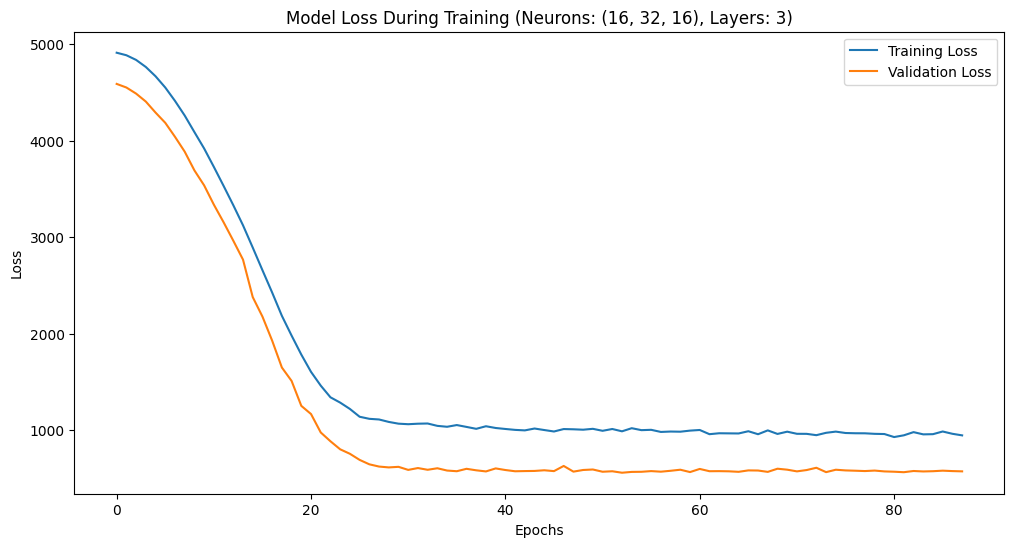

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on the Training Data: 18.74%
MAPE für Brot: 20.00%
MAPE für Broetchen: 12.43%
MAPE für Croissant: 17.84%
MAPE für Konditorei: 24.62%
MAPE für Kuchen: 13.31%
MAPE für Saisonbrot: 54.03%

MAPE on the Validation Data: 19.60%
MAPE für Brot: 20.18%
MAPE für Broetchen: 12.43%
MAPE für Croissant: 18.69%
MAPE für Konditorei: 25.39%
MAPE für Kuchen: 16.48%
MAPE für Saisonbrot: 50.39%
Training with 3 layers and neurons (16, 32, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4938.0234 - mae: 210.0158 - val_loss: 4553.7798 - val_mae: 194.6434
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4902.7319 - mae: 208.6041 - val_loss: 4493.5728 - val_mae: 192.2337
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4792.6665 - mae: 204.1991 - val_loss: 4382.5420 - val_mae: 187.7884
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4613.1611 - mae: 197.0083 - val_loss: 4208.0864 - val_mae: 180.8040
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4510.6934 - mae: 192.8823 - val_loss: 3999.7341 - val_mae: 172.4404
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4258.8711 - mae: 182.7622 - val_loss: 3757.1404 - val_mae: 162.6534
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4110.1445 - mae: 176.6937 - val_loss: 3501.8979 - val_mae: 152.2842
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3773.0378 - mae: 163.0534 - val_loss: 3215.7405 

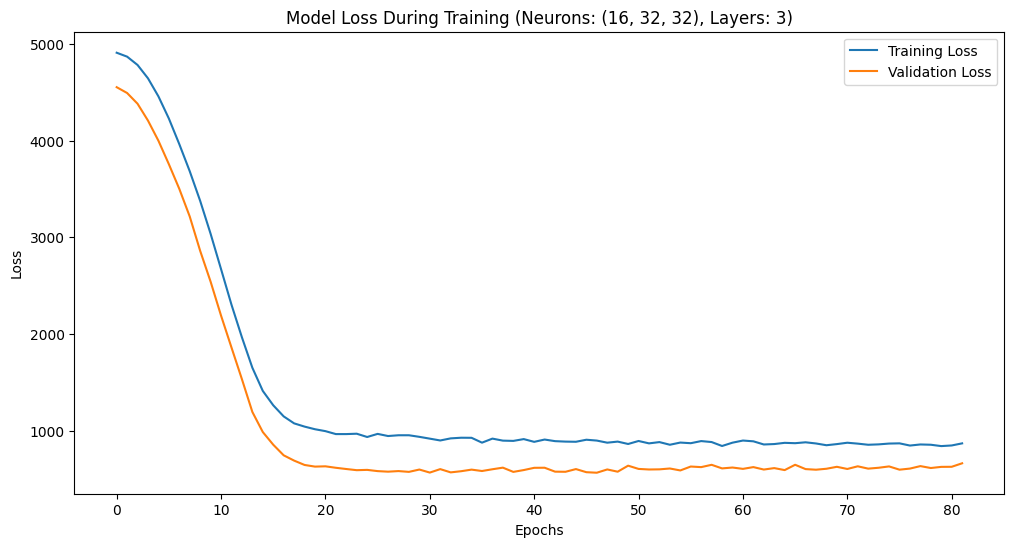

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
MAPE on the Training Data: 17.88%
MAPE für Brot: 19.17%
MAPE für Broetchen: 11.99%
MAPE für Croissant: 17.53%
MAPE für Konditorei: 22.17%
MAPE für Kuchen: 13.02%
MAPE für Saisonbrot: 52.99%

MAPE on the Validation Data: 20.24%
MAPE für Brot: 20.06%
MAPE für Broetchen: 12.67%
MAPE für Croissant: 20.88%
MAPE für Konditorei: 24.36%
MAPE für Kuchen: 16.59%
MAPE für Saisonbrot: 62.57%
Training with 3 layers and neurons (16, 32, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4945.9116 - mae: 210.3319 - val_loss: 4532.8013 - val_mae: 193.8034
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4806.5020 - mae: 204.7539 - val_loss: 4418.1025 - val_mae: 189.2117
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4720.9243 - mae: 201.3233 - val_loss: 4198.3584 - val_mae: 180.4058
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4499.6997 - mae: 192.4363 - val_loss: 3856.7151 - val_mae: 166.6799
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4111.8896 - mae: 176.8414 - val_loss: 3456.8867 - val_mae: 150.4842
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3756.6826 - mae: 162.3755 - val_loss: 3110.4443 - val_mae: 136.4939
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3244.5686 - mae: 141.6645 - val_loss: 2747.2327 - val_mae: 122.0543
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2708.8950 - mae: 120.0553 - val_loss: 2007.8728 

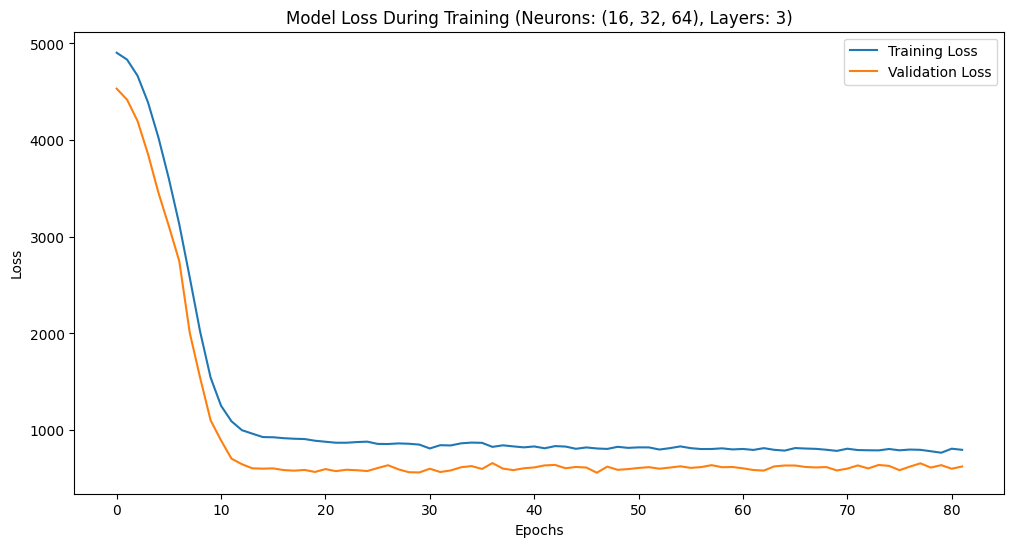

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 17.69%
MAPE für Brot: 18.95%
MAPE für Broetchen: 12.39%
MAPE für Croissant: 17.74%
MAPE für Konditorei: 21.48%
MAPE für Kuchen: 13.29%
MAPE für Saisonbrot: 47.12%

MAPE on the Validation Data: 19.72%
MAPE für Brot: 20.45%
MAPE für Broetchen: 13.70%
MAPE für Croissant: 19.06%
MAPE für Konditorei: 24.11%
MAPE für Kuchen: 14.93%
MAPE für Saisonbrot: 60.08%
Training with 3 layers and neurons (16, 32, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4859.2808 - mae: 206.8662 - val_loss: 4532.6328 - val_mae: 193.7961
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4863.3066 - mae: 207.0241 - val_loss: 4343.8960 - val_mae: 186.2424
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4494.8608 - mae: 192.2649 - val_loss: 3911.4341 - val_mae: 168.8822
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4064.2695 - mae: 174.8721 - val_loss: 3293.0908 - val_mae: 143.8546
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3421.0215 - mae: 148.8055 - val_loss: 2382.8623 - val_mae: 107.3450
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2619.5603 - mae: 116.6127 - val_loss: 1402.7089 - val_mae: 67.6434
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1830.9489 - mae: 84.6850 - val_loss: 1103.1406 - val_mae: 55.2280
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1268.9802 - mae: 61.7693 - val_loss: 801.0271 - val

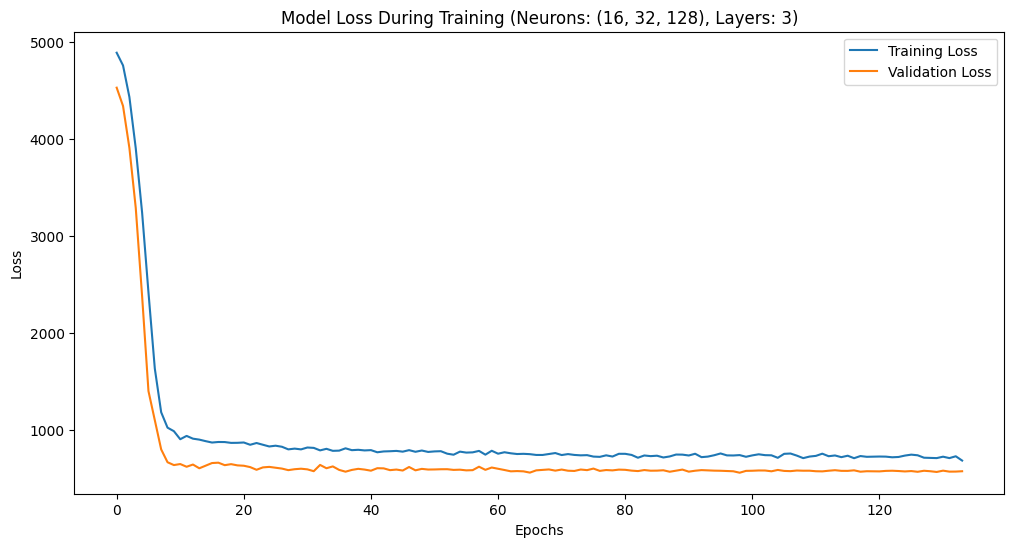

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on the Training Data: 17.58%
MAPE für Brot: 18.23%
MAPE für Broetchen: 10.42%
MAPE für Croissant: 16.24%
MAPE für Konditorei: 24.32%
MAPE für Kuchen: 12.15%
MAPE für Saisonbrot: 59.65%

MAPE on the Validation Data: 20.39%
MAPE für Brot: 19.70%
MAPE für Broetchen: 11.94%
MAPE für Croissant: 19.72%
MAPE für Konditorei: 26.88%
MAPE für Kuchen: 16.14%
MAPE für Saisonbrot: 68.76%
Training with 3 layers and neurons (16, 64, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4949.8501 - mae: 210.4892 - val_loss: 4562.8198 - val_mae: 195.0050
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4927.7178 - mae: 209.6023 - val_loss: 4531.1484 - val_mae: 193.7372
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4836.7275 - mae: 205.9607 - val_loss: 4479.2544 - val_mae: 191.6595
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4807.4111 - mae: 204.7886 - val_loss: 4390.6846 - val_mae: 188.1123
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4653.9224 - mae: 198.6447 - val_loss: 4291.9722 - val_mae: 184.1577
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4568.3501 - mae: 195.2082 - val_loss: 4154.7603 - val_mae: 178.6567
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4467.3799 - mae: 191.1382 - val_loss: 3986.7197 - val_mae: 171.9091
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4272.0303 - mae: 183.3025 - val_loss: 3819.4043 

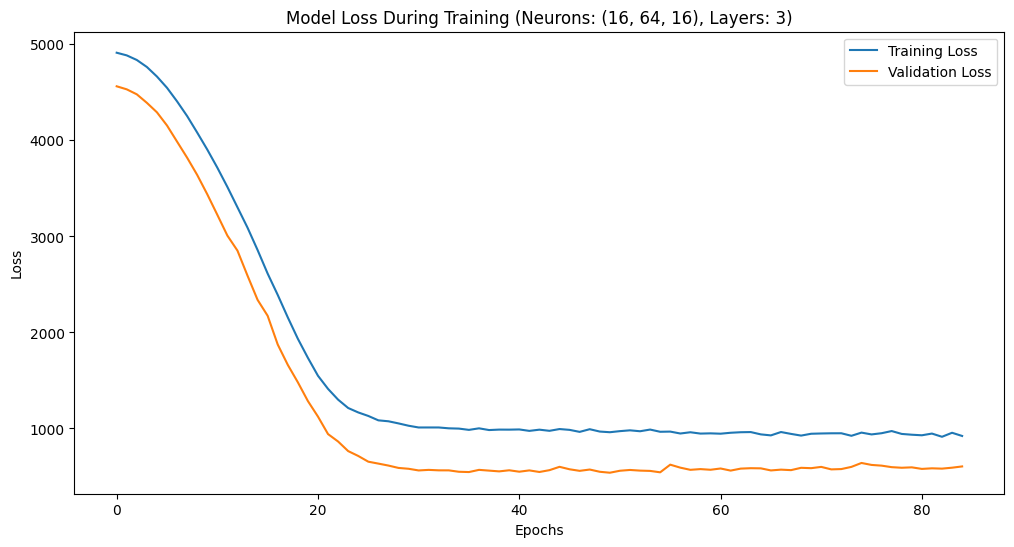

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
MAPE on the Training Data: 17.20%
MAPE für Brot: 17.59%
MAPE für Broetchen: 12.70%
MAPE für Croissant: 17.41%
MAPE für Konditorei: 20.56%
MAPE für Kuchen: 13.03%
MAPE für Saisonbrot: 47.09%

MAPE on the Validation Data: 18.80%
MAPE für Brot: 20.31%
MAPE für Broetchen: 11.74%
MAPE für Croissant: 18.76%
MAPE für Konditorei: 23.52%
MAPE für Kuchen: 14.55%
MAPE für Saisonbrot: 51.59%
Training with 3 layers and neurons (16, 64, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5006.5557 - mae: 212.7575 - val_loss: 4571.9077 - val_mae: 195.3685
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4849.1069 - mae: 206.4594 - val_loss: 4513.5688 - val_mae: 193.0344
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4769.2339 - mae: 203.2609 - val_loss: 4405.2017 - val_mae: 188.6965
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4728.4399 - mae: 201.6210 - val_loss: 4242.8174 - val_mae: 182.1960
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4474.7754 - mae: 191.4610 - val_loss: 4027.5063 - val_mae: 173.5637
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4355.1826 - mae: 186.6395 - val_loss: 3769.2009 - val_mae: 163.1694
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4072.8635 - mae: 175.2612 - val_loss: 3470.2324 - val_mae: 151.0585
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3704.0195 - mae: 160.2945 - val_loss: 3160.1157 

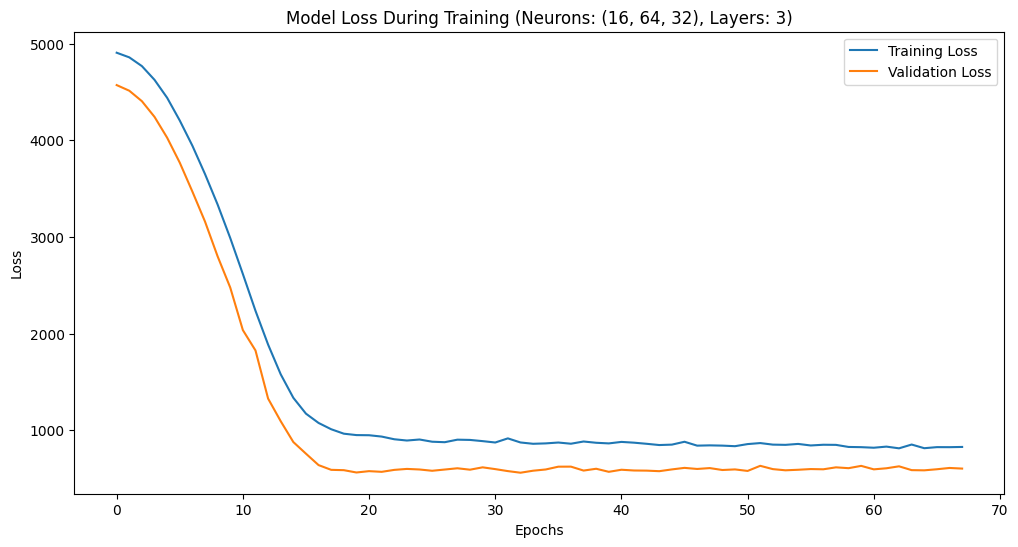

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MAPE on the Training Data: 17.91%
MAPE für Brot: 19.59%
MAPE für Broetchen: 12.62%
MAPE für Croissant: 18.10%
MAPE für Konditorei: 21.28%
MAPE für Kuchen: 13.22%
MAPE für Saisonbrot: 48.11%

MAPE on the Validation Data: 19.65%
MAPE für Brot: 19.16%
MAPE für Broetchen: 12.98%
MAPE für Croissant: 19.60%
MAPE für Konditorei: 25.13%
MAPE für Kuchen: 16.05%
MAPE für Saisonbrot: 53.72%
Training with 3 layers and neurons (16, 64, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4920.1460 - mae: 209.3006 - val_loss: 4559.0864 - val_mae: 194.8550
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4803.6992 - mae: 204.6419 - val_loss: 4466.5635 - val_mae: 191.1527
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4711.2729 - mae: 200.9391 - val_loss: 4262.6973 - val_mae: 182.9917
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4512.7451 - mae: 192.9769 - val_loss: 3965.7163 - val_mae: 171.0826
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4121.1221 - mae: 177.2221 - val_loss: 3555.9705 - val_mae: 154.5450
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3732.4160 - mae: 161.4248 - val_loss: 3127.1716 - val_mae: 137.2263
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3261.6523 - mae: 142.3585 - val_loss: 2704.2556 - val_mae: 120.3635
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2647.5547 - mae: 117.7113 - val_loss: 1956.9449 

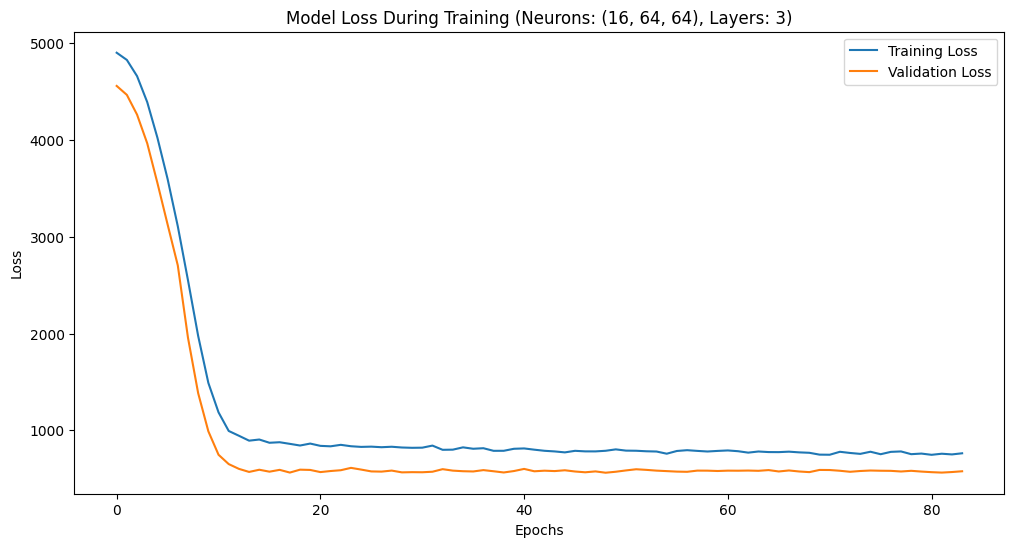

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
MAPE on the Training Data: 16.97%
MAPE für Brot: 18.19%
MAPE für Broetchen: 11.79%
MAPE für Croissant: 16.91%
MAPE für Konditorei: 20.73%
MAPE für Kuchen: 12.86%
MAPE für Saisonbrot: 44.79%

MAPE on the Validation Data: 19.26%
MAPE für Brot: 19.47%
MAPE für Broetchen: 12.00%
MAPE für Croissant: 19.99%
MAPE für Konditorei: 24.23%
MAPE für Kuchen: 17.21%
MAPE für Saisonbrot: 41.09%
Training with 3 layers and neurons (16, 64, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4960.2939 - mae: 210.9055 - val_loss: 4532.1196 - val_mae: 193.7739
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4712.0435 - mae: 200.9733 - val_loss: 4340.5020 - val_mae: 186.1014
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4592.8076 - mae: 196.1774 - val_loss: 3889.8765 - val_mae: 168.0089
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4014.7637 - mae: 172.8946 - val_loss: 3340.4055 - val_mae: 145.7411
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3448.9409 - mae: 149.8069 - val_loss: 2902.8074 - val_mae: 128.3720
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2600.0271 - mae: 115.7739 - val_loss: 1840.5216 - val_mae: 85.6941
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1757.1819 - mae: 81.8178 - val_loss: 1048.1744 - val_mae: 52.9791
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1209.5511 - mae: 59.3049 - val_loss: 728.2846 - val

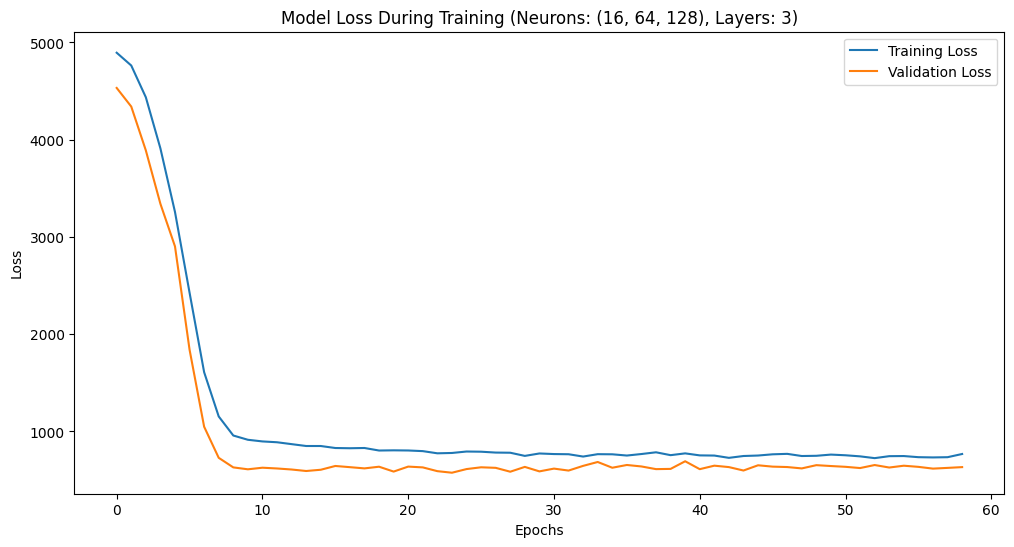

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on the Training Data: 18.04%
MAPE für Brot: 19.87%
MAPE für Broetchen: 12.55%
MAPE für Croissant: 17.40%
MAPE für Konditorei: 22.08%
MAPE für Kuchen: 13.09%
MAPE für Saisonbrot: 51.09%

MAPE on the Validation Data: 20.41%
MAPE für Brot: 21.81%
MAPE für Broetchen: 13.00%
MAPE für Croissant: 21.05%
MAPE für Konditorei: 24.54%
MAPE für Kuchen: 16.50%
MAPE für Saisonbrot: 53.30%
Training with 3 layers and neurons (16, 128, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4915.4902 - mae: 209.1143 - val_loss: 4543.5864 - val_mae: 194.2349
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4878.8350 - mae: 207.6469 - val_loss: 4519.0469 - val_mae: 193.2517
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4808.4233 - mae: 204.8304 - val_loss: 4476.9873 - val_mae: 191.5690
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4788.9038 - mae: 204.0414 - val_loss: 4407.5698 - val_mae: 188.7893
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4672.7427 - mae: 199.3973 - val_loss: 4308.5015 - val_mae: 184.8245
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4570.7256 - mae: 195.3061 - val_loss: 4176.3853 - val_mae: 179.5344
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4423.1646 - mae: 189.3823 - val_loss: 4028.0793 - val_mae: 173.5893
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4352.5459 - mae: 186.5350 - val_loss: 3868.5598 

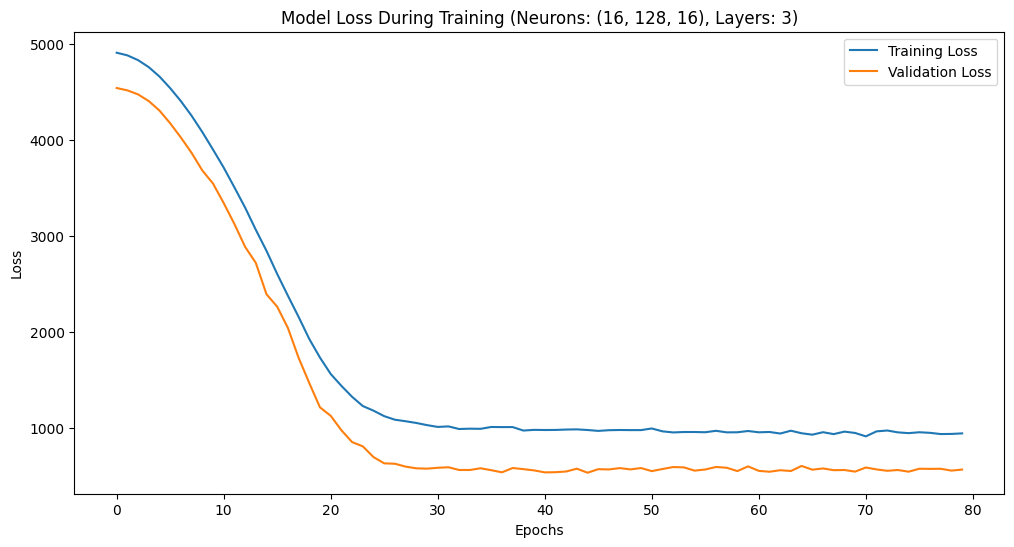

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
MAPE on the Training Data: 17.46%
MAPE für Brot: 18.16%
MAPE für Broetchen: 13.38%
MAPE für Croissant: 17.66%
MAPE für Konditorei: 20.84%
MAPE für Kuchen: 13.11%
MAPE für Saisonbrot: 43.82%

MAPE on the Validation Data: 18.82%
MAPE für Brot: 20.25%
MAPE für Broetchen: 11.58%
MAPE für Croissant: 18.05%
MAPE für Konditorei: 24.00%
MAPE für Kuchen: 15.32%
MAPE für Saisonbrot: 50.00%
Training with 3 layers and neurons (16, 128, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4948.6602 - mae: 210.4405 - val_loss: 4519.9541 - val_mae: 193.2881
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4921.5151 - mae: 209.3537 - val_loss: 4462.1313 - val_mae: 190.9727
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4782.2495 - mae: 203.7808 - val_loss: 4386.8423 - val_mae: 187.9585
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4674.2646 - mae: 199.4533 - val_loss: 4216.4507 - val_mae: 181.1356
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4502.7070 - mae: 192.5609 - val_loss: 4002.6729 - val_mae: 172.5546
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4306.3320 - mae: 184.6525 - val_loss: 3751.2539 - val_mae: 162.4223
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4076.7378 - mae: 175.3870 - val_loss: 3507.1238 - val_mae: 152.5656
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3752.4287 - mae: 162.2343 - val_loss: 3238.4990 

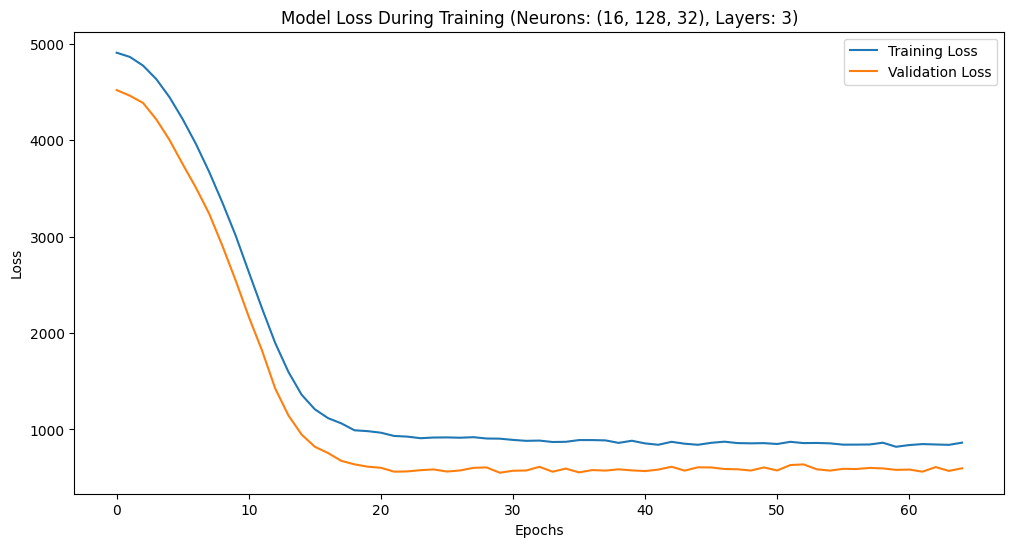

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
MAPE on the Training Data: 17.82%
MAPE für Brot: 18.84%
MAPE für Broetchen: 12.87%
MAPE für Croissant: 17.91%
MAPE für Konditorei: 22.25%
MAPE für Kuchen: 13.26%
MAPE für Saisonbrot: 43.39%

MAPE on the Validation Data: 19.12%
MAPE für Brot: 19.60%
MAPE für Broetchen: 13.31%
MAPE für Croissant: 17.85%
MAPE für Konditorei: 23.17%
MAPE für Kuchen: 15.83%
MAPE für Saisonbrot: 56.15%
Training with 3 layers and neurons (16, 128, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4904.3389 - mae: 208.6665 - val_loss: 4565.3716 - val_mae: 195.1051
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4810.2817 - mae: 204.9028 - val_loss: 4445.2476 - val_mae: 190.2950
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4788.6519 - mae: 204.0281 - val_loss: 4230.2627 - val_mae: 181.6791
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4472.6060 - mae: 191.3506 - val_loss: 3951.8169 - val_mae: 170.5159
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4128.9663 - mae: 177.5362 - val_loss: 3579.7007 - val_mae: 155.4898
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3678.8625 - mae: 159.2909 - val_loss: 3128.2458 - val_mae: 137.2213
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3218.9790 - mae: 140.6135 - val_loss: 2615.6860 - val_mae: 116.7920
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2785.9626 - mae: 123.3494 - val_loss: 1807.3069 

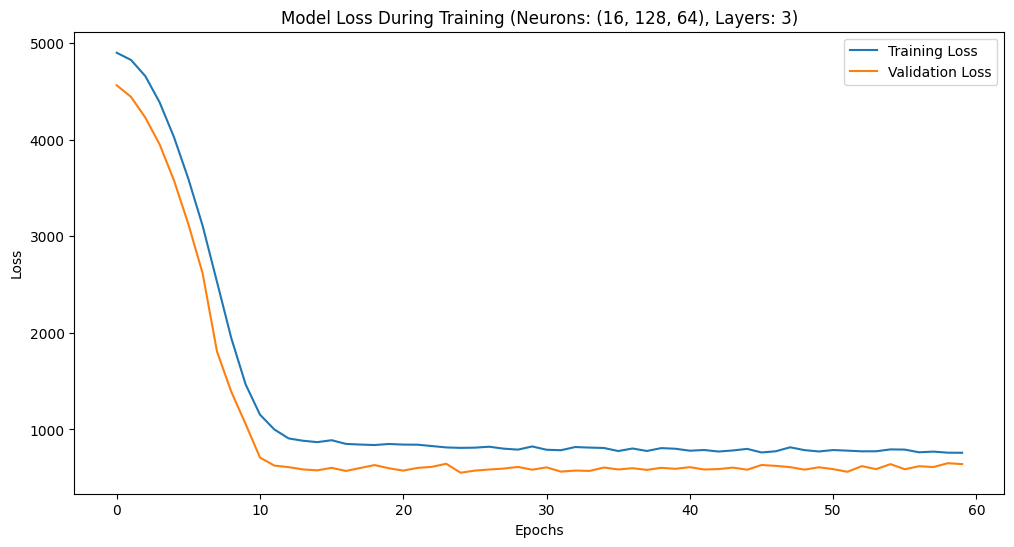

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 17.48%
MAPE für Brot: 18.51%
MAPE für Broetchen: 12.51%
MAPE für Croissant: 18.15%
MAPE für Konditorei: 20.46%
MAPE für Kuchen: 13.32%
MAPE für Saisonbrot: 45.64%

MAPE on the Validation Data: 19.25%
MAPE für Brot: 20.10%
MAPE für Broetchen: 13.87%
MAPE für Croissant: 18.90%
MAPE für Konditorei: 23.53%
MAPE für Kuchen: 14.93%
MAPE für Saisonbrot: 50.66%
Training with 3 layers and neurons (16, 128, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4890.1665 - mae: 208.0982 - val_loss: 4511.7129 - val_mae: 192.9552
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4757.4883 - mae: 202.7880 - val_loss: 4299.9648 - val_mae: 184.4789
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4540.2749 - mae: 194.0734 - val_loss: 3875.2119 - val_mae: 167.4355
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3941.3230 - mae: 170.0188 - val_loss: 3203.4998 - val_mae: 140.3016
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3445.5632 - mae: 149.8127 - val_loss: 2315.8318 - val_mae: 104.5937
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2538.4727 - mae: 113.3850 - val_loss: 1448.9557 - val_mae: 69.6303
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1740.3542 - mae: 81.1056 - val_loss: 923.5952 - val_mae: 47.6668
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1155.5491 - mae: 57.0526 - val_loss: 669.1230 - val_

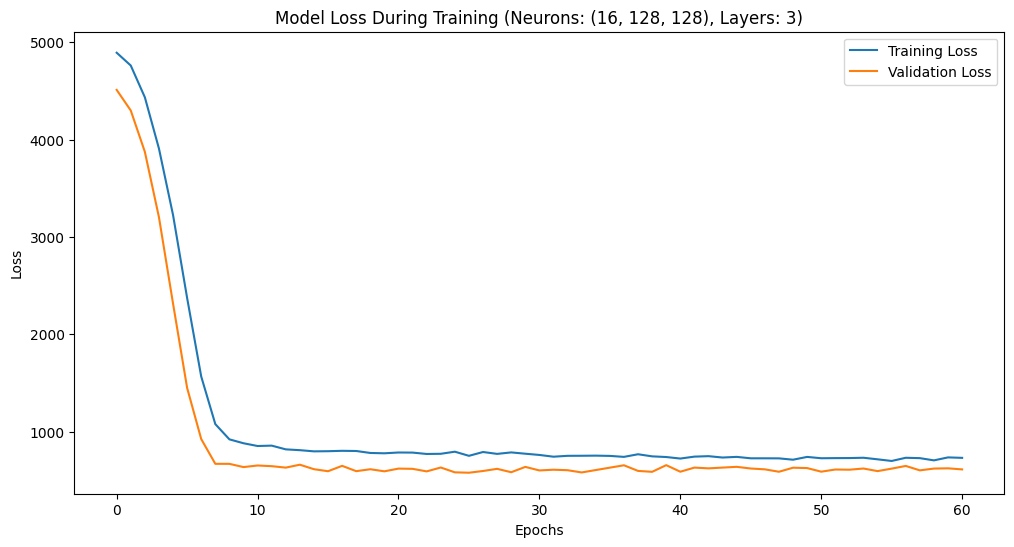

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 17.35%
MAPE für Brot: 18.46%
MAPE für Broetchen: 12.22%
MAPE für Croissant: 17.19%
MAPE für Konditorei: 20.88%
MAPE für Kuchen: 12.98%
MAPE für Saisonbrot: 49.34%

MAPE on the Validation Data: 19.80%
MAPE für Brot: 21.07%
MAPE für Broetchen: 13.31%
MAPE für Croissant: 18.90%
MAPE für Konditorei: 23.55%
MAPE für Kuchen: 17.59%
MAPE für Saisonbrot: 48.99%
Training with 3 layers and neurons (32, 16, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4946.3193 - mae: 210.3490 - val_loss: 4571.7861 - val_mae: 195.3647
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4848.6162 - mae: 206.4408 - val_loss: 4534.9556 - val_mae: 193.8913
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4922.4922 - mae: 209.3945 - val_loss: 4482.9209 - val_mae: 191.8085
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4789.1968 - mae: 204.0597 - val_loss: 4395.2856 - val_mae: 188.2984
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4680.8027 - mae: 199.7172 - val_loss: 4271.5786 - val_mae: 183.3450
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4633.3188 - mae: 197.8020 - val_loss: 4114.3936 - val_mae: 177.0397
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4447.8467 - mae: 190.3709 - val_loss: 3967.0635 - val_mae: 171.1223
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4230.4043 - mae: 181.6334 - val_loss: 3803.1650 

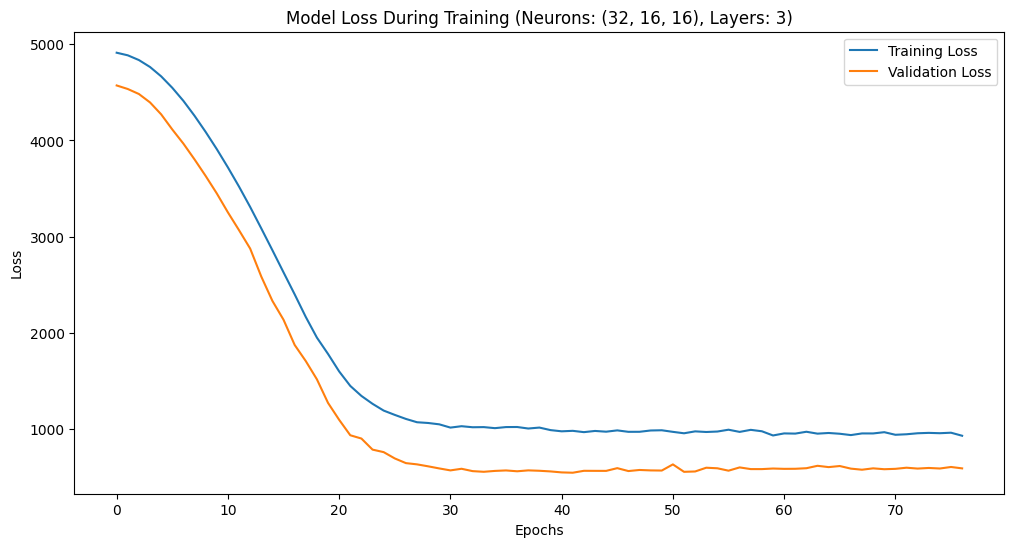

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on the Training Data: 17.72%
MAPE für Brot: 18.79%
MAPE für Broetchen: 12.52%
MAPE für Croissant: 17.42%
MAPE für Konditorei: 21.55%
MAPE für Kuchen: 13.05%
MAPE für Saisonbrot: 51.33%

MAPE on the Validation Data: 19.01%
MAPE für Brot: 21.10%
MAPE für Broetchen: 12.17%
MAPE für Croissant: 18.49%
MAPE für Konditorei: 22.84%
MAPE für Kuchen: 14.99%
MAPE für Saisonbrot: 53.70%
Training with 3 layers and neurons (32, 16, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4893.7573 - mae: 208.2466 - val_loss: 4577.7593 - val_mae: 195.6026
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4840.9712 - mae: 206.1339 - val_loss: 4503.7910 - val_mae: 192.6407
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4771.3599 - mae: 203.3475 - val_loss: 4400.2568 - val_mae: 188.4985
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4681.2959 - mae: 199.7324 - val_loss: 4214.8579 - val_mae: 181.0735
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4538.2651 - mae: 193.9947 - val_loss: 4015.8933 - val_mae: 173.0882
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4358.0815 - mae: 186.7455 - val_loss: 3739.3186 - val_mae: 161.9469
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4036.1531 - mae: 173.7673 - val_loss: 3480.8652 - val_mae: 151.4452
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3764.1074 - mae: 162.6788 - val_loss: 3166.4373 

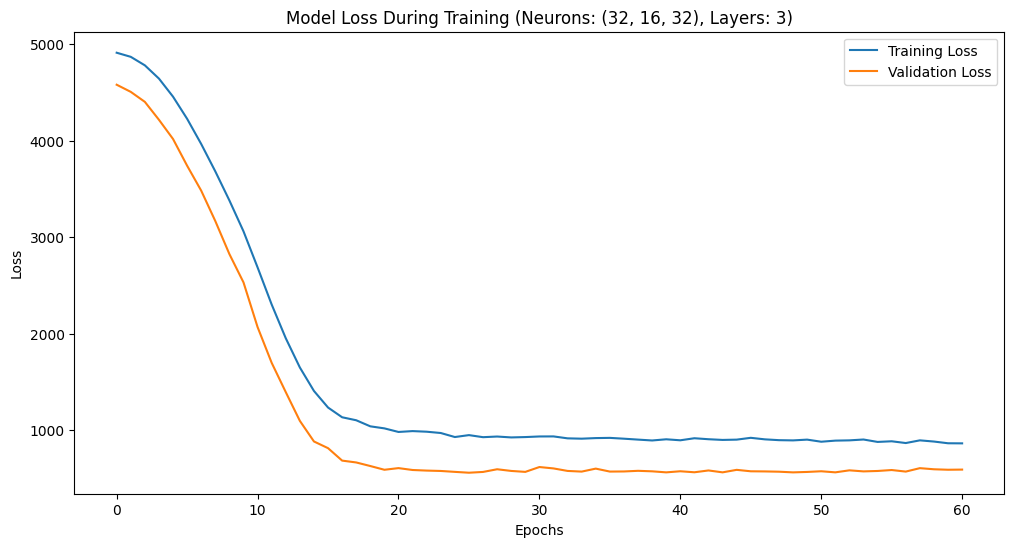

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 19.03%
MAPE für Brot: 20.49%
MAPE für Broetchen: 13.11%
MAPE für Croissant: 18.39%
MAPE für Konditorei: 24.33%
MAPE für Kuchen: 13.53%
MAPE für Saisonbrot: 53.21%

MAPE on the Validation Data: 20.05%
MAPE für Brot: 20.38%
MAPE für Broetchen: 14.13%
MAPE für Croissant: 19.97%
MAPE für Konditorei: 23.01%
MAPE für Kuchen: 15.88%
MAPE für Saisonbrot: 64.00%
Training with 3 layers and neurons (32, 16, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4947.3643 - mae: 210.3902 - val_loss: 4568.8945 - val_mae: 195.2478
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4910.2656 - mae: 208.9052 - val_loss: 4456.9551 - val_mae: 190.7667
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4681.8979 - mae: 199.7619 - val_loss: 4228.1045 - val_mae: 181.6043
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4431.6606 - mae: 189.7137 - val_loss: 3902.5745 - val_mae: 168.5429
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4125.1367 - mae: 177.3691 - val_loss: 3489.5701 - val_mae: 151.8173
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3811.9175 - mae: 164.6034 - val_loss: 2993.3511 - val_mae: 131.5722
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3212.4209 - mae: 140.2812 - val_loss: 2480.9785 - val_mae: 111.0349
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2665.2498 - mae: 118.3341 - val_loss: 1897.1997 

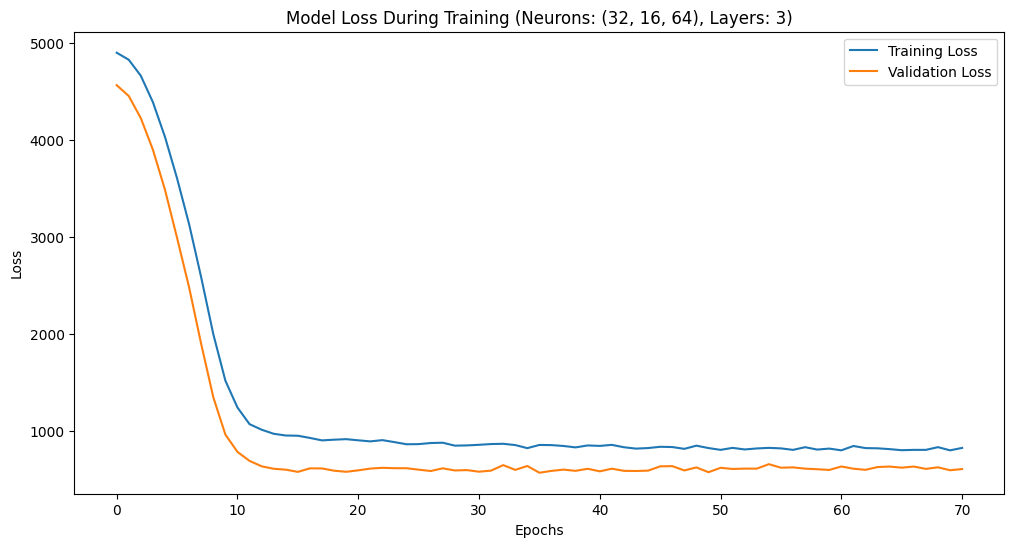

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 18.36%
MAPE für Brot: 19.11%
MAPE für Broetchen: 12.62%
MAPE für Croissant: 17.51%
MAPE für Konditorei: 23.84%
MAPE für Kuchen: 12.84%
MAPE für Saisonbrot: 55.91%

MAPE on the Validation Data: 20.07%
MAPE für Brot: 21.75%
MAPE für Broetchen: 12.51%
MAPE für Croissant: 19.13%
MAPE für Konditorei: 24.36%
MAPE für Kuchen: 16.65%
MAPE für Saisonbrot: 58.19%
Training with 3 layers and neurons (32, 16, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4893.0415 - mae: 208.2163 - val_loss: 4540.7974 - val_mae: 194.1234
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4748.3564 - mae: 202.4231 - val_loss: 4316.1689 - val_mae: 185.1327
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4534.9067 - mae: 193.8663 - val_loss: 3888.5876 - val_mae: 167.9661
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4065.5691 - mae: 174.9655 - val_loss: 3363.0308 - val_mae: 146.6891
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3415.3655 - mae: 148.4903 - val_loss: 2664.1335 - val_mae: 118.6668
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2588.6836 - mae: 115.3023 - val_loss: 1551.5017 - val_mae: 73.6831
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1861.6377 - mae: 85.9212 - val_loss: 1063.6772 - val_mae: 53.7921
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1268.0590 - mae: 61.7840 - val_loss: 763.9612 - val

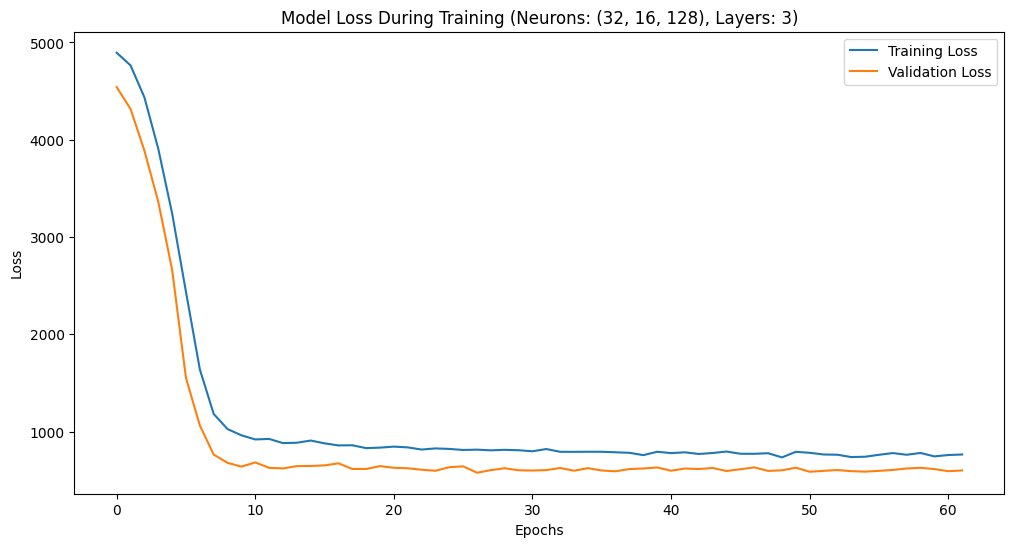

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
MAPE on the Training Data: 18.45%
MAPE für Brot: 20.47%
MAPE für Broetchen: 11.95%
MAPE für Croissant: 16.97%
MAPE für Konditorei: 23.75%
MAPE für Kuchen: 12.49%
MAPE für Saisonbrot: 60.51%

MAPE on the Validation Data: 20.53%
MAPE für Brot: 21.52%
MAPE für Broetchen: 13.24%
MAPE für Croissant: 19.88%
MAPE für Konditorei: 25.59%
MAPE für Kuchen: 15.89%
MAPE für Saisonbrot: 62.01%
Training with 3 layers and neurons (32, 32, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4893.0801 - mae: 208.2179 - val_loss: 4573.6172 - val_mae: 195.4375
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4878.0391 - mae: 207.6160 - val_loss: 4521.2910 - val_mae: 193.3443
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4904.3193 - mae: 208.6672 - val_loss: 4439.0015 - val_mae: 190.0514
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4752.9072 - mae: 202.6094 - val_loss: 4333.8364 - val_mae: 185.8413
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4651.7173 - mae: 198.5575 - val_loss: 4236.9995 - val_mae: 181.9611
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4596.2021 - mae: 196.3246 - val_loss: 4089.7625 - val_mae: 176.0568
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4367.7119 - mae: 187.1670 - val_loss: 3932.4658 - val_mae: 169.7332
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4311.6655 - mae: 184.8846 - val_loss: 3752.3005 

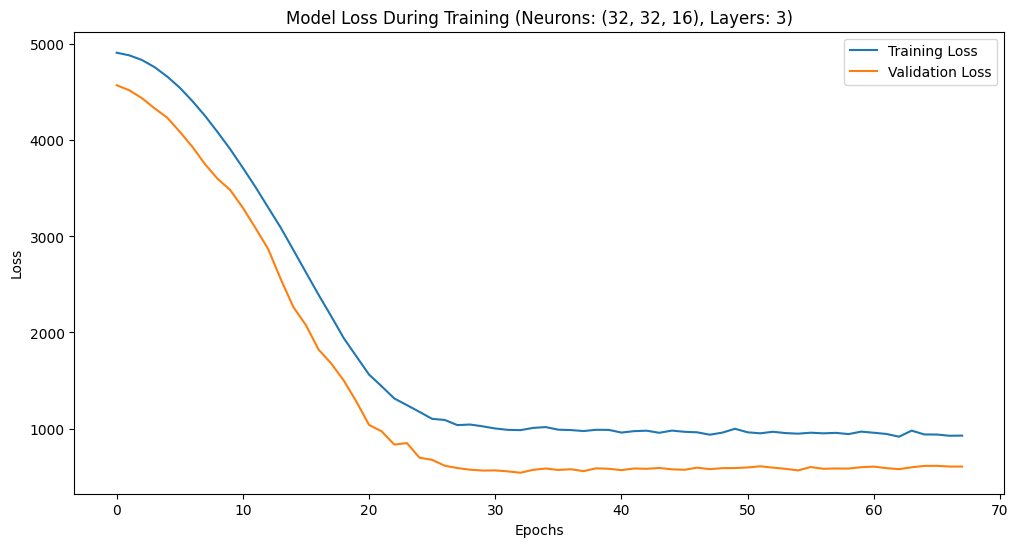

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 18.39%
MAPE für Brot: 18.85%
MAPE für Broetchen: 13.39%
MAPE für Croissant: 17.81%
MAPE für Konditorei: 23.15%
MAPE für Kuchen: 13.27%
MAPE für Saisonbrot: 53.28%

MAPE on the Validation Data: 19.23%
MAPE für Brot: 20.71%
MAPE für Broetchen: 12.90%
MAPE für Croissant: 18.97%
MAPE für Konditorei: 23.34%
MAPE für Kuchen: 14.60%
MAPE für Saisonbrot: 55.03%
Training with 3 layers and neurons (32, 32, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4954.2051 - mae: 210.6625 - val_loss: 4565.4937 - val_mae: 195.1112
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4847.2354 - mae: 206.3826 - val_loss: 4497.0083 - val_mae: 192.3688
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4798.9736 - mae: 204.4476 - val_loss: 4377.6724 - val_mae: 187.5907
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4691.9438 - mae: 200.1593 - val_loss: 4204.0732 - val_mae: 180.6397
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4501.7646 - mae: 192.5294 - val_loss: 4016.5352 - val_mae: 173.1223
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4202.8989 - mae: 180.5373 - val_loss: 3729.6545 - val_mae: 161.5632
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4079.6052 - mae: 175.5266 - val_loss: 3451.2246 - val_mae: 150.2726
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3811.7065 - mae: 164.5987 - val_loss: 3156.7512 

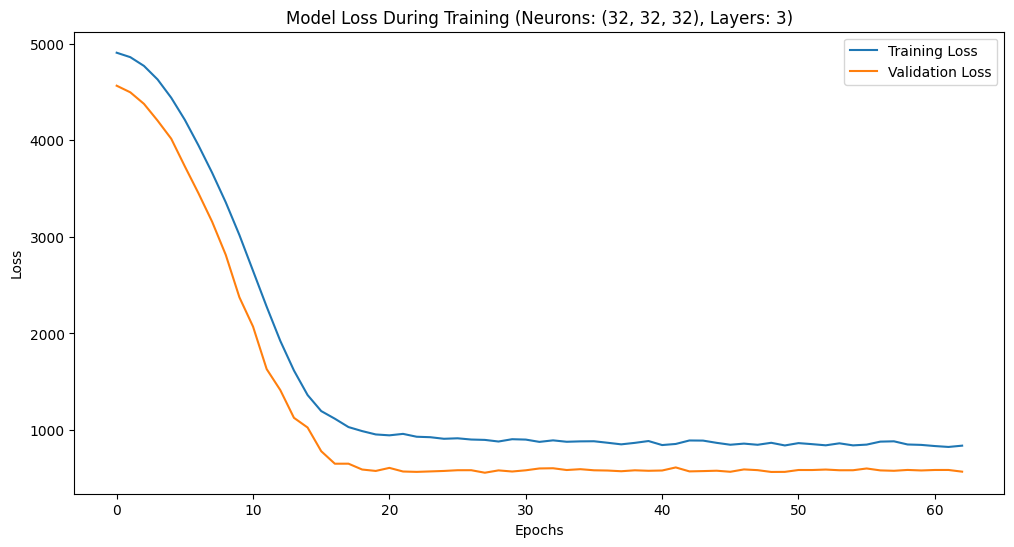

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on the Training Data: 18.47%
MAPE für Brot: 20.34%
MAPE für Broetchen: 12.50%
MAPE für Croissant: 18.21%
MAPE für Konditorei: 22.85%
MAPE für Kuchen: 13.03%
MAPE für Saisonbrot: 52.97%

MAPE on the Validation Data: 19.48%
MAPE für Brot: 20.84%
MAPE für Broetchen: 12.23%
MAPE für Croissant: 19.60%
MAPE für Konditorei: 22.26%
MAPE für Kuchen: 16.99%
MAPE für Saisonbrot: 54.35%
Training with 3 layers and neurons (32, 32, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4882.1284 - mae: 207.7792 - val_loss: 4554.2568 - val_mae: 194.6614
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4784.8984 - mae: 203.8896 - val_loss: 4438.9463 - val_mae: 190.0468
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4751.3003 - mae: 202.5407 - val_loss: 4220.7139 - val_mae: 181.3067
Epoch 4/150
 43/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4715.2876 - mae: 201.0430

: 

In [4]:
# Wenn es eine gespeicherte Datei gibt, lade die Ergebnisse
try:
    with open('model_results.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []

# Funktion, um zu prüfen, ob ein Modell bereits getestet wurde
def is_model_tested(neurons_list, num_layers, results):
    for result in results:
        if result['neurons_list'] == neurons_list and result['num_layers'] == num_layers:
            return True
    return False

# Funktion zum Erstellen und Trainieren des Modells
def create_and_train_model(input_shape, neurons_list, num_layers, lr_schedule, loss, x_train, y_train, x_val, y_val):
    # Erstelle das Modell
    model = tf.keras.Sequential()
    
    # Erstelle die Schichten basierend auf der Anzahl der Schichten und Neuronen
    model.add(tf.keras.layers.Dense(neurons_list[0], activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)))
    for i in range(1, num_layers):
        model.add(tf.keras.layers.Dense(neurons_list[i], activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))  # Keine Aktivierungsfunktion im Output
    
    # Kompiliere das Modell
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=loss, metrics=['mae'])
    
    # Trainiere das Modell
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    return model, history

# Liste der verfügbaren Neuronenzahlen für jede Schicht
neurons_options = [16, 32, 64, 128]

# Parameter
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.9
)
loss = Huber(delta=25)

# Modell für jede Kombination von Neuronenanzahl und Schichten trainieren
results = []

# Für jede Anzahl an Schichten (3 und 4 Schichten)
for num_layers in range(3, 5):  # Teste 3 und 4 Schichten
    # Für jede Kombination von Neuronenanzahl (z.B. [16], [32, 32], etc.)
    for neurons_list in itertools.product(neurons_options, repeat=num_layers):
        if is_model_tested(neurons_list, num_layers, results):
            print(f"Skipping {num_layers} layers with neurons {neurons_list} (already tested).")
            continue
        print(f"Training with {len(neurons_list)} layers and neurons {neurons_list}...")
        
        model, history = create_and_train_model(
            input_shape=len(features), 
            neurons_list=neurons_list, 
            num_layers=num_layers, 
            lr_schedule=lr_schedule, 
            loss=loss, 
            x_train=x_train, 
            y_train=y_train, 
            x_val=x_val, 
            y_val=y_val
        )
        
        # Visualisiere den Trainingsverlauf
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss During Training (Neurons: {neurons_list}, Layers: {num_layers})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Berechne Vorhersagen für Training und Validierung
        training_predictions = model.predict(x_train)
        validation_predictions = model.predict(x_val)

        # DataFrames für Vorhersagen
        train_predictions_df = pd.DataFrame({
            'Datum': train_data['Datum'],
            'id': train_data['id'],
            'Tatsächlicher Umsatz': y_train,
            'Vorhergesagter Umsatz': training_predictions.flatten()
        })
        
        val_predictions_df = pd.DataFrame({
            'Datum': val_data['Datum'],
            'id': val_data['id'],
            'Tatsächlicher Umsatz': y_val,
            'Vorhergesagter Umsatz': validation_predictions.flatten()
        })

        # Mapping für Warengruppen
        ware_mapping = {
            1: 'Brot',
            2: 'Broetchen',
            3: 'Croissant',
            4: 'Konditorei',
            5: 'Kuchen',
            6: 'Saisonbrot'
        }

        # MAPE berechnen
        train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

        val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year

        def calculate_mape(y_true, y_pred):
            non_zero_mask = y_true != 0
            return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        
        # calc total mape
        train_mape = calculate_mape(train_predictions_df['Tatsächlicher Umsatz'], train_predictions_df['Vorhergesagter Umsatz'])
        val_mape = calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz'])

        # Speichere das Modell, den Verlauf der Verluste und MAPE-Werte
        results.append({
            'neurons_list': neurons_list,
            'num_layers': num_layers,
            'history': history,
            'model': model,
            'train_mape': train_mape,
            'val_mape': val_mape
        })

        # Speichere die Ergebnisse nach jeder Iteration
        with open('model_results.pkl', 'wb') as f:
            pickle.dump(results, f)

        print(f"MAPE on the Training Data: {train_mape:.2f}%")
        for group in train_predictions_df['Warengruppe'].unique():
            group_data = train_predictions_df[train_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

        print(f"\nMAPE on the Validation Data: {val_mape:.2f}%")
        for group in val_predictions_df['Warengruppe'].unique():
            group_data = val_predictions_df[val_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

# Finde das beste Modell anhand des MAPE der Validierungsdaten
best_model = min(results, key=lambda x: calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz']))
print(f"Best Model: {best_model['neurons_list']} neurons, {best_model['num_layers']} layers")

### Versuch 2: 4 Schicht Modelle 
Neuronanenanzahl 16 - 32 -64 - 128 Kombinationen
Kernel stirbt auch nach einigen Modellen
Ergebnisse der 3-Schicht Modelle passen besser

Training with 4 layers and neurons (16, 16, 16, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4924.1699 - mae: 209.4617 - val_loss: 4572.3721 - val_mae: 195.3877
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4925.4639 - mae: 209.5140 - val_loss: 4528.4297 - val_mae: 193.6286
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4911.3555 - mae: 208.9475 - val_loss: 4466.9028 - val_mae: 191.1651
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4859.4282 - mae: 206.8679 - val_loss: 4379.5688 - val_mae: 187.6692
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4704.7773 - mae: 200.6783 - val_loss: 4273.3394 - val_mae: 183.4158
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4618.7632 - mae: 197.2249 - val_loss: 4135.9990 - val_mae: 177.9100
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4387.0845 - mae: 187.9454 - val_loss: 3984.1689 - val_mae: 171.8142
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4318.6479 - mae: 185.1717 - val_loss: 3824.4556 

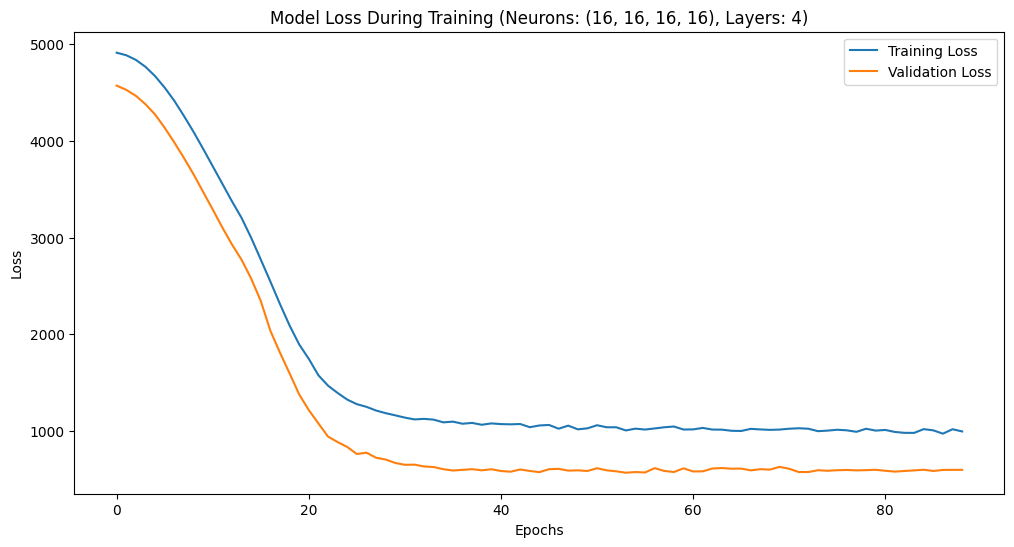

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
MAPE on the Training Data: 19.32%
MAPE für Brot: 20.04%
MAPE für Broetchen: 12.80%
MAPE für Croissant: 17.71%
MAPE für Konditorei: 26.22%
MAPE für Kuchen: 13.60%
MAPE für Saisonbrot: 59.41%

MAPE on the Validation Data: 20.27%
MAPE für Brot: 20.92%
MAPE für Broetchen: 12.87%
MAPE für Croissant: 17.86%
MAPE für Konditorei: 25.76%
MAPE für Kuchen: 16.84%
MAPE für Saisonbrot: 65.48%
Training with 4 layers and neurons (16, 16, 16, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4886.1787 - mae: 207.9422 - val_loss: 4569.7842 - val_mae: 195.2837
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4961.5752 - mae: 210.9581 - val_loss: 4502.4844 - val_mae: 192.5898
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4810.0903 - mae: 204.8939 - val_loss: 4396.7095 - val_mae: 188.3564
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4576.4746 - mae: 195.5403 - val_loss: 4218.7207 - val_mae: 181.2283
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4455.1045 - mae: 190.6632 - val_loss: 4017.4861 - val_mae: 173.1470
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4268.9399 - mae: 183.1513 - val_loss: 3765.1086 - val_mae: 162.9477
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4058.8337 - mae: 174.6416 - val_loss: 3500.0618 - val_mae: 152.1870
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3759.8149 - mae: 162.4606 - val_loss: 3220.6174 

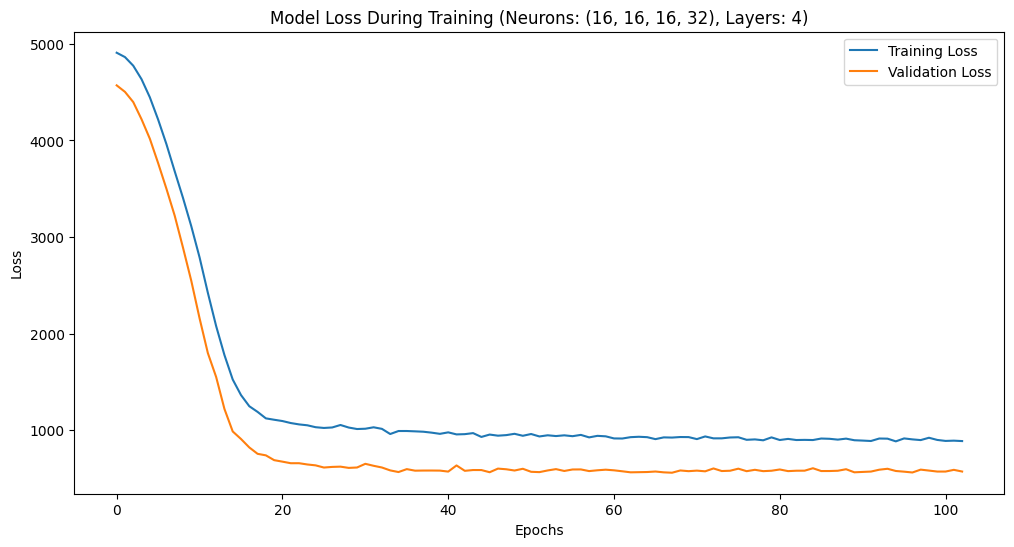

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on the Training Data: 18.69%
MAPE für Brot: 20.50%
MAPE für Broetchen: 12.52%
MAPE für Croissant: 17.22%
MAPE für Konditorei: 23.31%
MAPE für Kuchen: 13.23%
MAPE für Saisonbrot: 61.17%

MAPE on the Validation Data: 20.34%
MAPE für Brot: 22.25%
MAPE für Broetchen: 12.45%
MAPE für Croissant: 19.12%
MAPE für Konditorei: 24.45%
MAPE für Kuchen: 15.67%
MAPE für Saisonbrot: 69.81%
Training with 4 layers and neurons (16, 16, 16, 64)...


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4875.9385 - mae: 207.5328 - val_loss: 4543.7075 - val_mae: 194.2397
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4868.0093 - mae: 207.2141 - val_loss: 4421.5649 - val_mae: 189.3497
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4729.7017 - mae: 201.6744 - val_loss: 4188.0649 - val_mae: 179.9966
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4595.6255 - mae: 196.2866 - val_loss: 3871.4729 - val_mae: 167.2700
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4125.8340 - mae: 177.3711 - val_loss: 3485.6418 - val_mae: 151.6339
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3746.3782 - mae: 161.9312 - val_loss: 3072.0715 - val_mae: 134.7414
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3319.4023 - mae: 144.4176 - val_loss: 2616.7727 - val_mae: 116.2715
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2845.1404 - mae: 125.2583 - val_loss

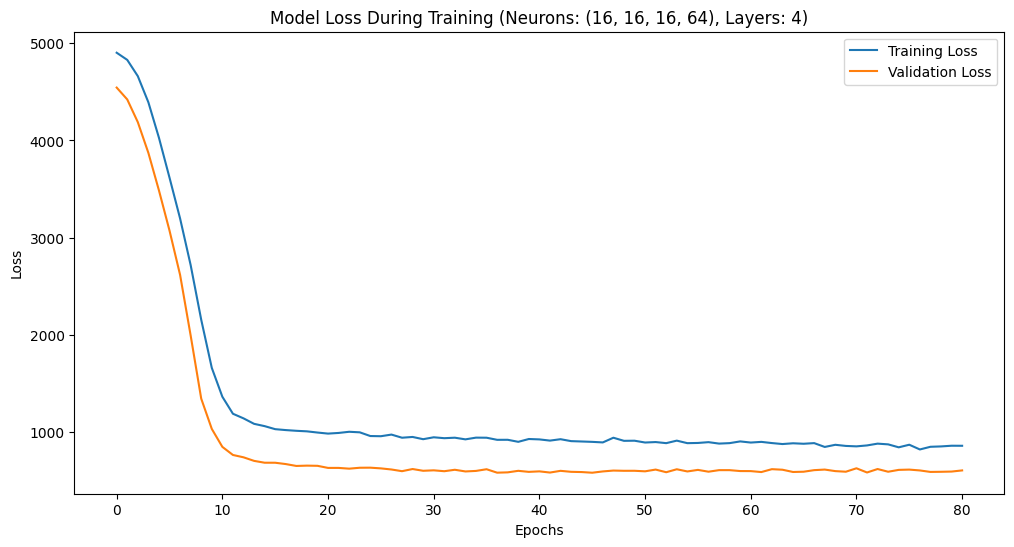

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
MAPE on the Training Data: 19.91%
MAPE für Brot: 20.81%
MAPE für Broetchen: 12.43%
MAPE für Croissant: 18.09%
MAPE für Konditorei: 28.06%
MAPE für Kuchen: 13.46%
MAPE für Saisonbrot: 63.31%

MAPE on the Validation Data: 21.25%
MAPE für Brot: 21.45%
MAPE für Broetchen: 13.47%
MAPE für Croissant: 19.74%
MAPE für Konditorei: 26.32%
MAPE für Kuchen: 17.36%
MAPE für Saisonbrot: 71.70%
Training with 4 layers and neurons (16, 16, 16, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5027.8218 - mae: 213.6079 - val_loss: 4544.9922 - val_mae: 194.2915
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4760.7290 - mae: 202.9214 - val_loss: 4326.0239 - val_mae: 185.5261
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4518.5723 - mae: 193.2068 - val_loss: 3891.0654 - val_mae: 168.0799
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4029.8574 - mae: 173.5060 - val_loss: 3292.8496 - val_mae: 143.7990
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3463.2593 - mae: 150.3006 - val_loss: 2624.9929 - val_mae: 116.5424
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2714.9045 - mae: 120.1130 - val_loss: 1594.3604 - val_mae: 75.1722
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1964.8051 - mae: 89.9435 - val_loss: 1181.2284 - val_mae: 58.1691
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1453.0375 - mae: 69.2377 - val_loss: 805.6779 - val

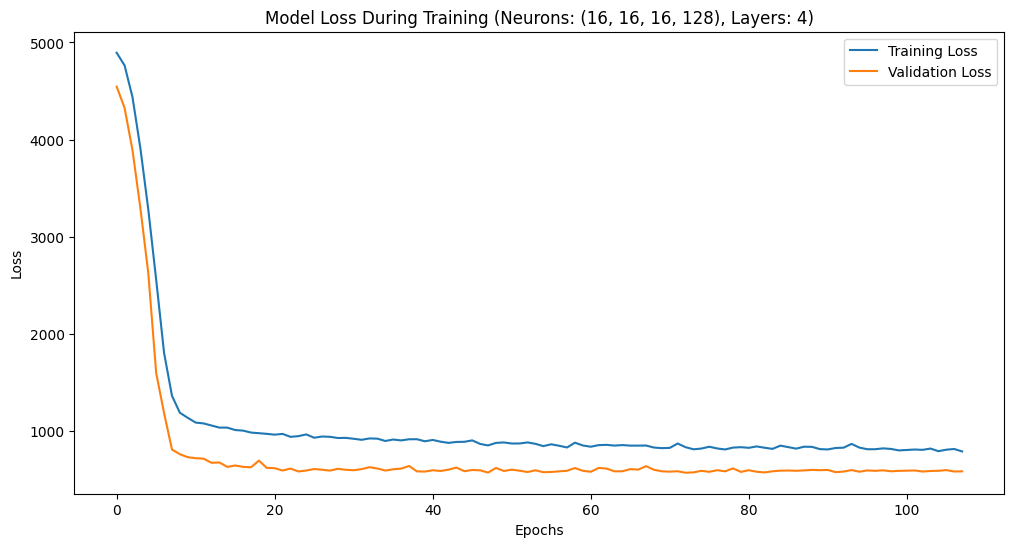

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
MAPE on the Training Data: 20.20%
MAPE für Brot: 22.64%
MAPE für Broetchen: 12.37%
MAPE für Croissant: 17.93%
MAPE für Konditorei: 27.74%
MAPE für Kuchen: 13.06%
MAPE für Saisonbrot: 66.95%

MAPE on the Validation Data: 21.66%
MAPE für Brot: 23.83%
MAPE für Broetchen: 11.61%
MAPE für Croissant: 19.60%
MAPE für Konditorei: 28.87%
MAPE für Kuchen: 16.95%
MAPE für Saisonbrot: 69.11%
Training with 4 layers and neurons (16, 16, 32, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4938.7432 - mae: 210.0448 - val_loss: 4580.0298 - val_mae: 195.6939
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4910.7930 - mae: 208.9262 - val_loss: 4541.9097 - val_mae: 194.1679
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4837.8931 - mae: 206.0082 - val_loss: 4475.4897 - val_mae: 191.5091
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4724.1406 - mae: 201.4543 - val_loss: 4390.9097 - val_mae: 188.1233
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4706.9009 - mae: 200.7556 - val_loss: 4286.5376 - val_mae: 183.9426
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4614.8896 - mae: 197.0659 - val_loss: 4160.2832 - val_mae: 178.8825
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4406.9927 - mae: 188.7177 - val_loss: 4012.1931 - val_mae: 172.9369
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4271.1064 - mae: 183.2327 - val_loss: 3860.6821 

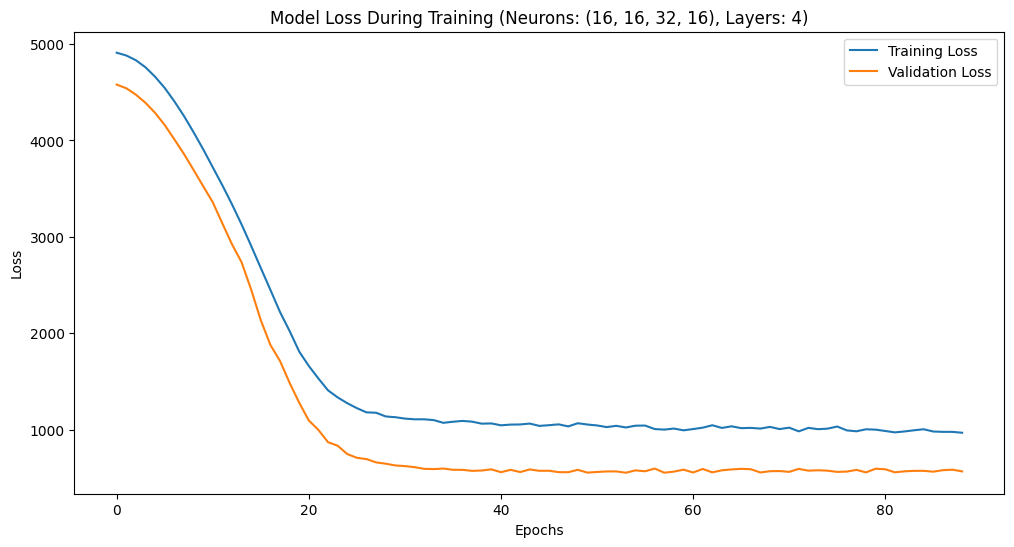

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
MAPE on the Training Data: 19.35%
MAPE für Brot: 19.94%
MAPE für Broetchen: 12.91%
MAPE für Croissant: 18.32%
MAPE für Konditorei: 26.22%
MAPE für Kuchen: 13.21%
MAPE für Saisonbrot: 58.95%

MAPE on the Validation Data: 20.14%
MAPE für Brot: 21.48%
MAPE für Broetchen: 12.38%
MAPE für Croissant: 21.10%
MAPE für Konditorei: 24.05%
MAPE für Kuchen: 15.42%
MAPE für Saisonbrot: 60.19%
Training with 4 layers and neurons (16, 16, 32, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4909.8247 - mae: 208.8885 - val_loss: 4592.3516 - val_mae: 196.1868
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4861.1167 - mae: 206.9391 - val_loss: 4530.2144 - val_mae: 193.7000
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4822.6548 - mae: 205.3973 - val_loss: 4419.5479 - val_mae: 189.2691
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4683.0034 - mae: 199.8017 - val_loss: 4250.8057 - val_mae: 182.5108
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4486.0620 - mae: 191.9130 - val_loss: 4045.4146 - val_mae: 174.2710
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4203.6353 - mae: 180.5436 - val_loss: 3781.8860 - val_mae: 163.6712
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4001.8264 - mae: 172.3700 - val_loss: 3521.5093 - val_mae: 153.1353
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3785.3589 - mae: 163.5538 - val_loss: 3179.5864 

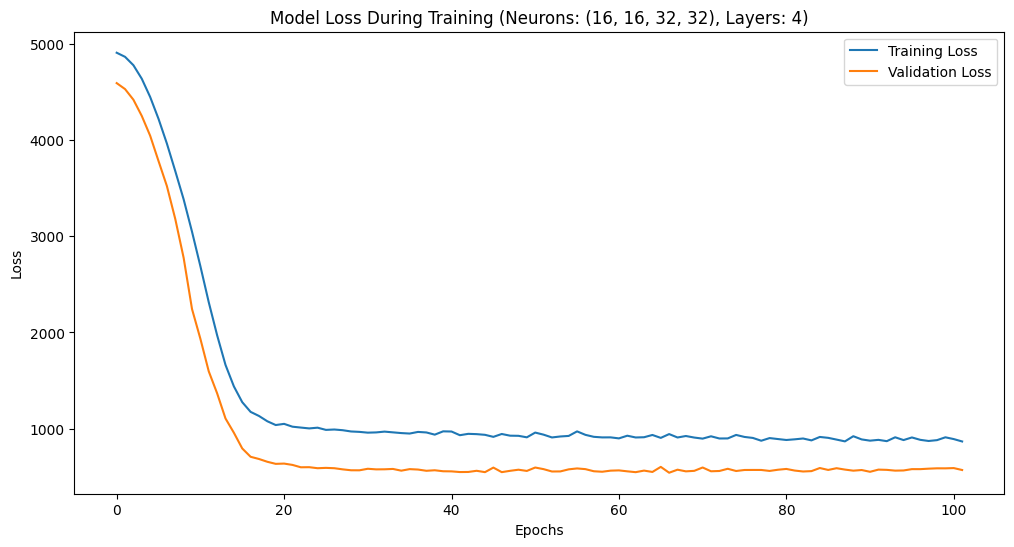

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 18.25%
MAPE für Brot: 19.28%
MAPE für Broetchen: 12.22%
MAPE für Croissant: 17.56%
MAPE für Konditorei: 22.53%
MAPE für Kuchen: 13.13%
MAPE für Saisonbrot: 59.84%

MAPE on the Validation Data: 19.54%
MAPE für Brot: 19.74%
MAPE für Broetchen: 12.59%
MAPE für Croissant: 19.51%
MAPE für Konditorei: 24.07%
MAPE für Kuchen: 14.30%
MAPE für Saisonbrot: 67.42%
Training with 4 layers and neurons (16, 16, 32, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4849.3970 - mae: 206.4706 - val_loss: 4544.7036 - val_mae: 194.2791
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4940.7876 - mae: 210.1239 - val_loss: 4425.1577 - val_mae: 189.4927
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4709.0430 - mae: 200.8456 - val_loss: 4207.7471 - val_mae: 180.7843
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4413.7104 - mae: 189.0007 - val_loss: 3869.0774 - val_mae: 167.1485
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4096.6528 - mae: 176.2119 - val_loss: 3470.6150 - val_mae: 151.0188
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3726.5217 - mae: 161.0885 - val_loss: 3016.3713 - val_mae: 132.4397
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3288.8835 - mae: 143.1632 - val_loss: 2471.0996 - val_mae: 110.2742
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2807.3459 - mae: 123.8659 - val_loss: 1734.5421 

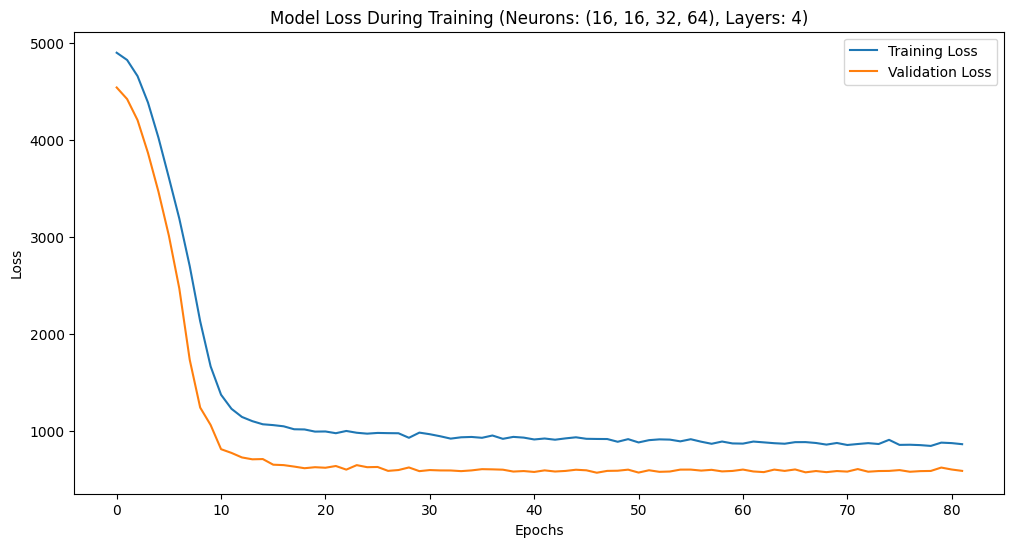

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
MAPE on the Training Data: 19.56%
MAPE für Brot: 19.43%
MAPE für Broetchen: 13.50%
MAPE für Croissant: 19.16%
MAPE für Konditorei: 26.01%
MAPE für Kuchen: 13.82%
MAPE für Saisonbrot: 57.40%

MAPE on the Validation Data: 20.59%
MAPE für Brot: 19.43%
MAPE für Broetchen: 14.38%
MAPE für Croissant: 21.61%
MAPE für Konditorei: 24.14%
MAPE für Kuchen: 15.62%
MAPE für Saisonbrot: 69.98%
Training with 4 layers and neurons (16, 16, 32, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4943.5352 - mae: 210.2356 - val_loss: 4545.3892 - val_mae: 194.3058
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4761.7358 - mae: 202.9595 - val_loss: 4323.4673 - val_mae: 185.4219
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4532.5942 - mae: 193.7726 - val_loss: 3884.1528 - val_mae: 167.7702
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4073.1416 - mae: 175.2538 - val_loss: 3261.3184 - val_mae: 142.5151
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3426.3577 - mae: 148.8305 - val_loss: 2442.0588 - val_mae: 109.0172
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2818.8489 - mae: 124.3065 - val_loss: 1334.2885 - val_mae: 64.3916
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1983.4030 - mae: 90.7923 - val_loss: 943.2727 - val_mae: 48.5004
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1365.8052 - mae: 65.6974 - val_loss: 810.5656 - val_

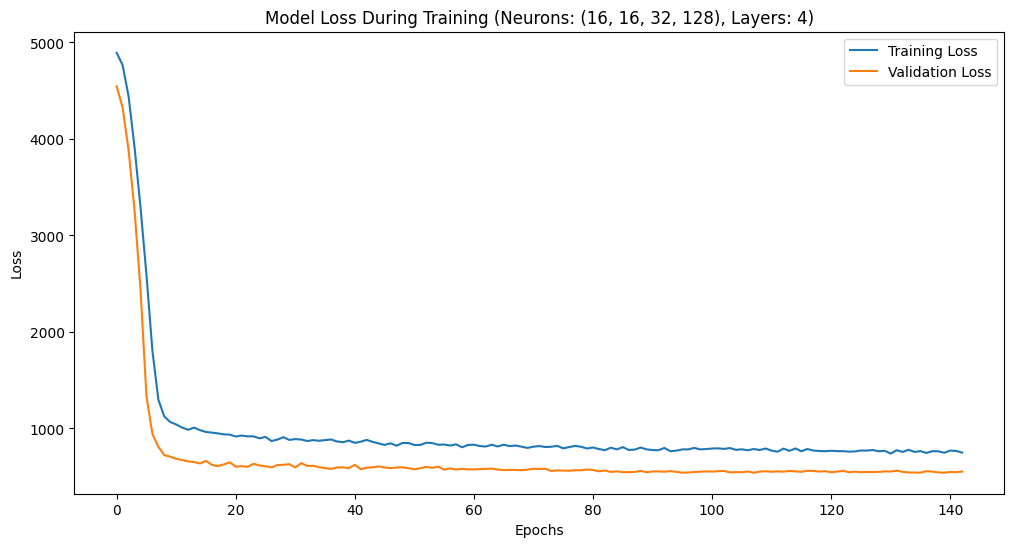

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
MAPE on the Training Data: 17.65%
MAPE für Brot: 19.08%
MAPE für Broetchen: 10.97%
MAPE für Croissant: 17.01%
MAPE für Konditorei: 22.07%
MAPE für Kuchen: 12.47%
MAPE für Saisonbrot: 59.88%

MAPE on the Validation Data: 19.37%
MAPE für Brot: 19.48%
MAPE für Broetchen: 12.68%
MAPE für Croissant: 18.65%
MAPE für Konditorei: 23.72%
MAPE für Kuchen: 14.67%
MAPE für Saisonbrot: 68.27%
Training with 4 layers and neurons (16, 16, 64, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4956.9731 - mae: 210.7742 - val_loss: 4579.3120 - val_mae: 195.6651
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4931.6279 - mae: 209.7596 - val_loss: 4535.9404 - val_mae: 193.9297
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4822.8311 - mae: 205.4058 - val_loss: 4478.5054 - val_mae: 191.6309
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4772.7949 - mae: 203.4037 - val_loss: 4401.9707 - val_mae: 188.5656
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4679.6460 - mae: 199.6693 - val_loss: 4293.9683 - val_mae: 184.2417
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4569.7729 - mae: 195.2711 - val_loss: 4161.0801 - val_mae: 178.9181
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4443.3413 - mae: 190.1849 - val_loss: 4020.6536 - val_mae: 173.2778
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4269.0552 - mae: 183.1749 - val_loss: 3854.6240 

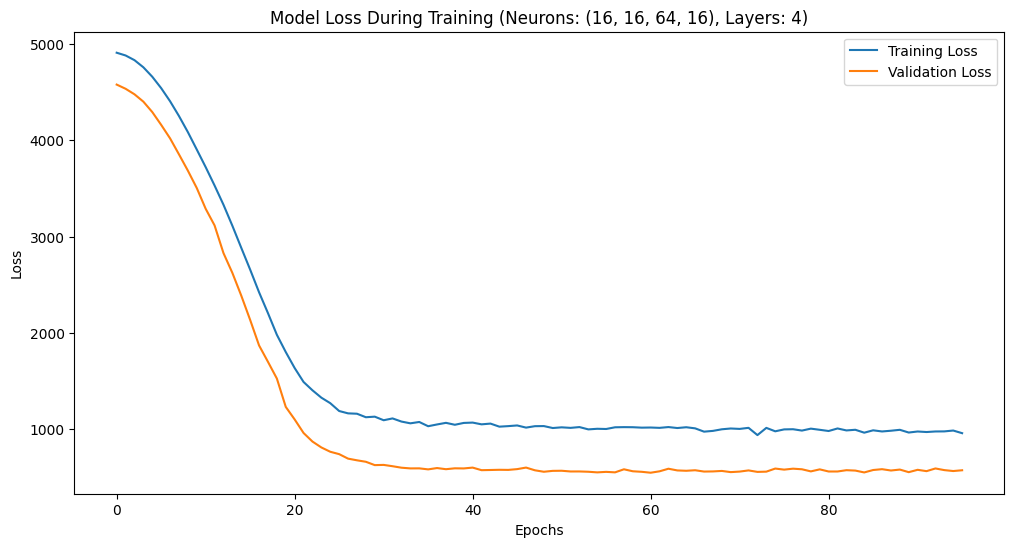

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
MAPE on the Training Data: 18.79%
MAPE für Brot: 19.74%
MAPE für Broetchen: 12.66%
MAPE für Croissant: 18.06%
MAPE für Konditorei: 23.58%
MAPE für Kuchen: 13.50%
MAPE für Saisonbrot: 59.44%

MAPE on the Validation Data: 20.15%
MAPE für Brot: 20.74%
MAPE für Broetchen: 12.49%
MAPE für Croissant: 18.53%
MAPE für Konditorei: 26.02%
MAPE für Kuchen: 15.20%
MAPE für Saisonbrot: 69.67%
Training with 4 layers and neurons (16, 16, 64, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4900.9092 - mae: 208.5300 - val_loss: 4570.7617 - val_mae: 195.3219
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4933.5337 - mae: 209.8333 - val_loss: 4507.3198 - val_mae: 192.7830
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4801.3726 - mae: 204.5469 - val_loss: 4394.6968 - val_mae: 188.2728
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4636.5044 - mae: 197.9459 - val_loss: 4226.7227 - val_mae: 181.5435
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4514.1431 - mae: 193.0289 - val_loss: 4005.6599 - val_mae: 172.6690
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4317.3140 - mae: 185.1142 - val_loss: 3763.6624 - val_mae: 162.9101
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4038.1863 - mae: 173.8428 - val_loss: 3476.0330 - val_mae: 151.2955
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3701.9368 - mae: 160.2013 - val_loss: 3254.0803 

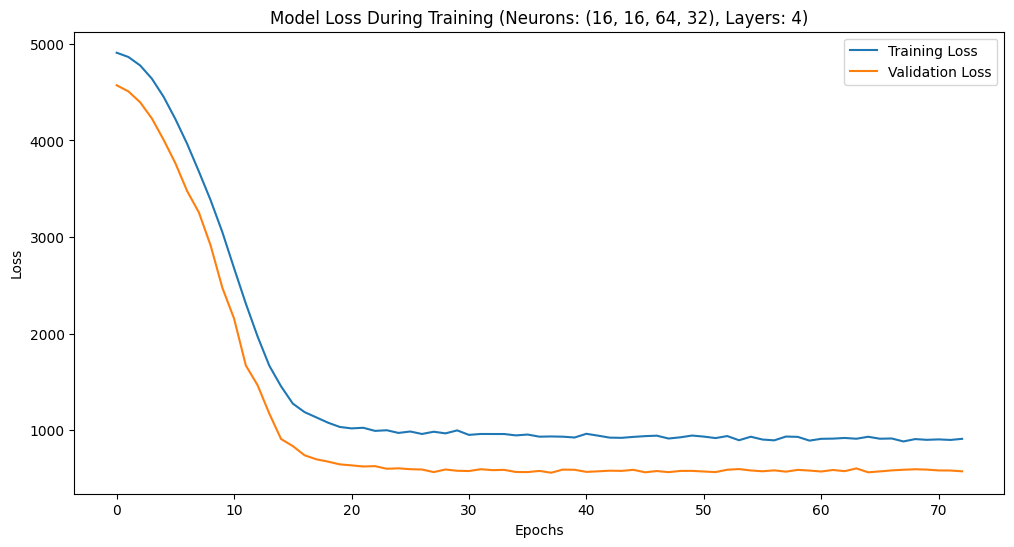

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
MAPE on the Training Data: 19.21%
MAPE für Brot: 20.85%
MAPE für Broetchen: 13.26%
MAPE für Croissant: 18.52%
MAPE für Konditorei: 25.20%
MAPE für Kuchen: 13.94%
MAPE für Saisonbrot: 47.03%

MAPE on the Validation Data: 19.62%
MAPE für Brot: 20.24%
MAPE für Broetchen: 12.98%
MAPE für Croissant: 19.66%
MAPE für Konditorei: 23.65%
MAPE für Kuchen: 15.77%
MAPE für Saisonbrot: 56.58%
Training with 4 layers and neurons (16, 16, 64, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4881.4336 - mae: 207.7508 - val_loss: 4552.0679 - val_mae: 194.5728
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4859.8970 - mae: 206.8889 - val_loss: 4441.8188 - val_mae: 190.1585
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4743.9238 - mae: 202.2407 - val_loss: 4197.8184 - val_mae: 180.3816
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4440.6816 - mae: 190.0864 - val_loss: 3894.5913 - val_mae: 168.1951
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4168.0078 - mae: 179.0867 - val_loss: 3556.0757 - val_mae: 154.5130
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3709.9697 - mae: 160.4655 - val_loss: 3156.6587 - val_mae: 138.2436
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3361.2864 - mae: 146.1670 - val_loss: 2676.5718 - val_mae: 118.9025
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2776.9460 - mae: 122.7058 - val_loss: 2055.3982 

: 

In [6]:
# Wenn es eine gespeicherte Datei gibt, lade die Ergebnisse
try:
    with open('model_results.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []

# Funktion, um zu prüfen, ob ein Modell bereits getestet wurde
def is_model_tested(neurons_list, num_layers, results):
    for result in results:
        if result['neurons_list'] == neurons_list and result['num_layers'] == num_layers:
            return True
    return False

# Funktion zum Erstellen und Trainieren des Modells
def create_and_train_model(input_shape, neurons_list, num_layers, lr_schedule, loss, x_train, y_train, x_val, y_val):
    # Erstelle das Modell
    model = tf.keras.Sequential()
    
    # Erstelle die Schichten basierend auf der Anzahl der Schichten und Neuronen
    model.add(tf.keras.layers.Dense(neurons_list[0], activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)))
    for i in range(1, num_layers):
        model.add(tf.keras.layers.Dense(neurons_list[i], activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))  # Keine Aktivierungsfunktion im Output
    
    # Kompiliere das Modell
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=loss, metrics=['mae'])
    
    # Trainiere das Modell
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    return model, history

# Liste der verfügbaren Neuronenzahlen für jede Schicht
neurons_options = [16, 32, 64, 128]

# Parameter
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.9
)
loss = Huber(delta=25)

# Modell für jede Kombination von Neuronenanzahl und Schichten trainieren
results = []

# Für jede Anzahl an Schichten (3 und 4 Schichten)
for num_layers in range(4, 5):  # Teste 3 und 4 Schichten
    # Für jede Kombination von Neuronenanzahl (z.B. [16], [32, 32], etc.)
    for neurons_list in itertools.product(neurons_options, repeat=num_layers):
        if is_model_tested(neurons_list, num_layers, results):
            print(f"Skipping {num_layers} layers with neurons {neurons_list} (already tested).")
            continue
        print(f"Training with {len(neurons_list)} layers and neurons {neurons_list}...")
        
        model, history = create_and_train_model(
            input_shape=len(features), 
            neurons_list=neurons_list, 
            num_layers=num_layers, 
            lr_schedule=lr_schedule, 
            loss=loss, 
            x_train=x_train, 
            y_train=y_train, 
            x_val=x_val, 
            y_val=y_val
        )
        
        # Visualisiere den Trainingsverlauf
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss During Training (Neurons: {neurons_list}, Layers: {num_layers})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Berechne Vorhersagen für Training und Validierung
        training_predictions = model.predict(x_train)
        validation_predictions = model.predict(x_val)

        # DataFrames für Vorhersagen
        train_predictions_df = pd.DataFrame({
            'Datum': train_data['Datum'],
            'id': train_data['id'],
            'Tatsächlicher Umsatz': y_train,
            'Vorhergesagter Umsatz': training_predictions.flatten()
        })
        
        val_predictions_df = pd.DataFrame({
            'Datum': val_data['Datum'],
            'id': val_data['id'],
            'Tatsächlicher Umsatz': y_val,
            'Vorhergesagter Umsatz': validation_predictions.flatten()
        })

        # Mapping für Warengruppen
        ware_mapping = {
            1: 'Brot',
            2: 'Broetchen',
            3: 'Croissant',
            4: 'Konditorei',
            5: 'Kuchen',
            6: 'Saisonbrot'
        }

        # MAPE berechnen
        train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

        val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year

        def calculate_mape(y_true, y_pred):
            non_zero_mask = y_true != 0
            return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        
        # calc total mape
        train_mape = calculate_mape(train_predictions_df['Tatsächlicher Umsatz'], train_predictions_df['Vorhergesagter Umsatz'])
        val_mape = calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz'])

        # Speichere das Modell, den Verlauf der Verluste und MAPE-Werte
        results.append({
            'neurons_list': neurons_list,
            'num_layers': num_layers,
            'history': history,
            'model': model,
            'train_mape': train_mape,
            'val_mape': val_mape
        })

        # Speichere die Ergebnisse nach jeder Iteration
        with open('model_results.pkl', 'wb') as f:
            pickle.dump(results, f)

        print(f"MAPE on the Training Data: {train_mape:.2f}%")
        for group in train_predictions_df['Warengruppe'].unique():
            group_data = train_predictions_df[train_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

        print(f"\nMAPE on the Validation Data: {val_mape:.2f}%")
        for group in val_predictions_df['Warengruppe'].unique():
            group_data = val_predictions_df[val_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

# Finde das beste Modell anhand des MAPE der Validierungsdaten
best_model = min(results, key=lambda x: calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz']))
print(f"Best Model: {best_model['neurons_list']} neurons, {best_model['num_layers']} layers")

### 3. Versuch: 3-Schicht Modelle 
Neuronenanzahl: 128 - 64 -32

Es sieht besser aus, wenn man in der ersten Schicht 128 Neuronen nimmt

Beste Kombinationen:

128 - 64 - 64 

128 - 128 - 32

2025-01-07 15:56:08.266962: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training with 3 layers and neurons (128, 128, 128)...


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4880.1167 - mae: 207.6896 - val_loss: 4526.6792 - val_mae: 193.5494
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4860.0894 - mae: 206.8885 - val_loss: 4293.7817 - val_mae: 184.2277
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4511.3608 - mae: 192.9279 - val_loss: 3911.7422 - val_mae: 168.9207
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4016.2083 - mae: 173.0309 - val_loss: 3251.7651 - val_mae: 142.3714
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3290.5149 - mae: 143.7913 - val_loss: 2464.8728 - val_mae: 110.9245
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2629.9753 - mae: 117.2218 - val_loss: 1728.2880 - val_mae: 81.1414
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1705.6064 - mae: 79.7002 - val_loss: 1105.1193 - val_mae: 55.5022
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1123.6700 - mae: 55.7700 - val_loss: 65

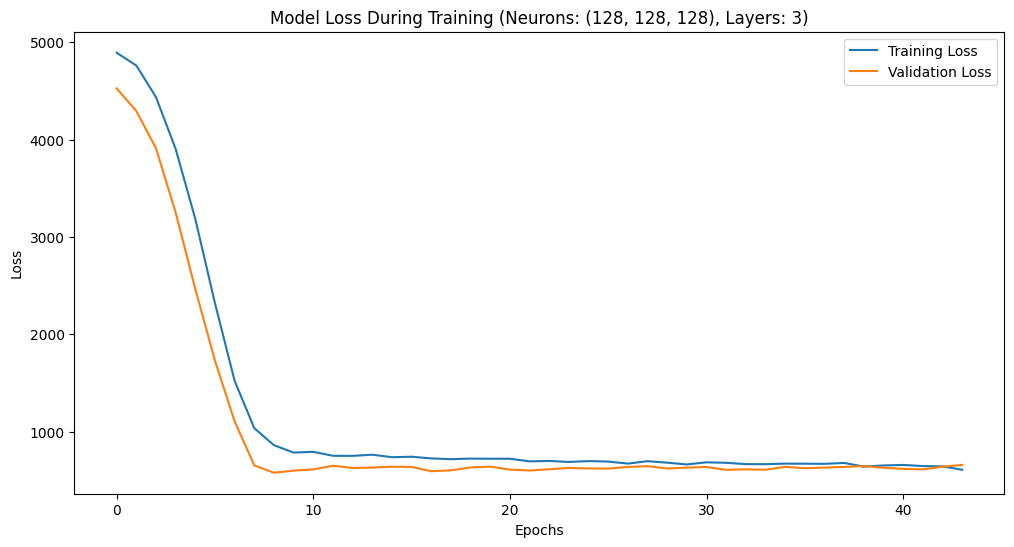

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
MAPE on the Training Data: 17.61%
MAPE für Brot: 18.96%
MAPE für Broetchen: 13.11%
MAPE für Croissant: 17.73%
MAPE für Konditorei: 21.61%
MAPE für Kuchen: 13.03%
MAPE für Saisonbrot: 40.89%

MAPE on the Validation Data: 19.16%
MAPE für Brot: 21.44%
MAPE für Broetchen: 12.79%
MAPE für Croissant: 18.63%
MAPE für Konditorei: 23.13%
MAPE für Kuchen: 15.59%
MAPE für Saisonbrot: 45.91%
Training with 3 layers and neurons (128, 128, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4918.2290 - mae: 209.2167 - val_loss: 4544.7515 - val_mae: 194.2740
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4904.3330 - mae: 208.6596 - val_loss: 4401.0845 - val_mae: 188.5221
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4778.9272 - mae: 203.6363 - val_loss: 4185.6772 - val_mae: 179.8986
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4489.2847 - mae: 192.0173 - val_loss: 3841.4971 - val_mae: 166.0825
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4132.9761 - mae: 177.6935 - val_loss: 3383.5759 - val_mae: 147.6130
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3661.1184 - mae: 158.6727 - val_loss: 2879.6223 - val_mae: 127.2701
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3230.4397 - mae: 141.3466 - val_loss: 2457.8044 - val_mae: 110.5806
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2602.9314 - mae: 116.1612 - val_loss: 2060.0437 

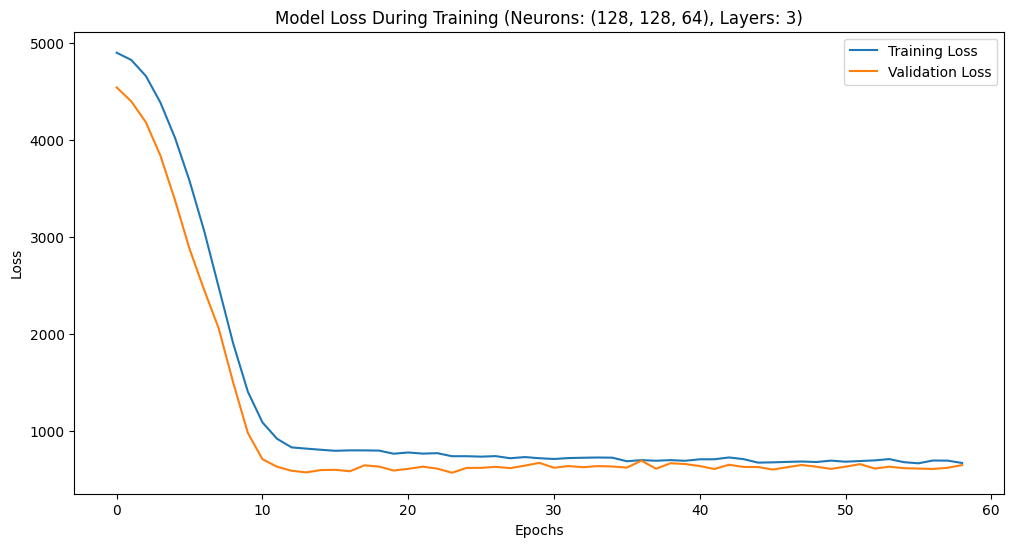

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
MAPE on the Training Data: 15.86%
MAPE für Brot: 17.06%
MAPE für Broetchen: 11.15%
MAPE für Croissant: 16.09%
MAPE für Konditorei: 18.93%
MAPE für Kuchen: 11.92%
MAPE für Saisonbrot: 42.11%

MAPE on the Validation Data: 19.66%
MAPE für Brot: 21.56%
MAPE für Broetchen: 12.89%
MAPE für Croissant: 20.57%
MAPE für Konditorei: 23.74%
MAPE für Kuchen: 15.63%
MAPE für Saisonbrot: 44.72%
Training with 3 layers and neurons (128, 128, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4978.7979 - mae: 211.6402 - val_loss: 4538.0830 - val_mae: 194.0082
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4919.4102 - mae: 209.2648 - val_loss: 4490.7041 - val_mae: 192.1116
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4760.5806 - mae: 202.9095 - val_loss: 4385.0752 - val_mae: 187.8855
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4702.8228 - mae: 200.5916 - val_loss: 4219.5518 - val_mae: 181.2565
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4553.8989 - mae: 194.6127 - val_loss: 4013.3960 - val_mae: 172.9834
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4267.4756 - mae: 183.1041 - val_loss: 3728.5916 - val_mae: 161.5313
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3998.7808 - mae: 172.3030 - val_loss: 3420.1506 - val_mae: 149.0880
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3766.8848 - mae: 162.9410 - val_loss: 3091.6311 

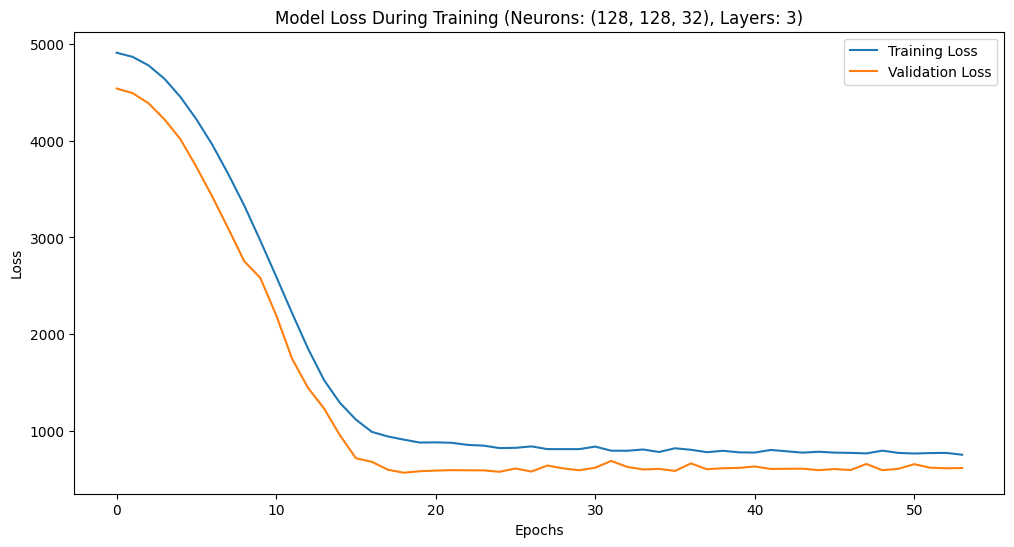

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 16.55%
MAPE für Brot: 17.31%
MAPE für Broetchen: 13.65%
MAPE für Croissant: 16.60%
MAPE für Konditorei: 19.59%
MAPE für Kuchen: 12.51%
MAPE für Saisonbrot: 36.48%

MAPE on the Validation Data: 19.02%
MAPE für Brot: 20.35%
MAPE für Broetchen: 13.50%
MAPE für Croissant: 18.98%
MAPE für Konditorei: 23.68%
MAPE für Kuchen: 14.97%
MAPE für Saisonbrot: 42.08%
Training with 3 layers and neurons (128, 64, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4923.2104 - mae: 209.4175 - val_loss: 4507.9399 - val_mae: 192.8025
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4827.3667 - mae: 205.5833 - val_loss: 4296.3369 - val_mae: 184.3319
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4547.2183 - mae: 194.3578 - val_loss: 3889.4341 - val_mae: 168.0073
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4005.9023 - mae: 172.5781 - val_loss: 3262.1458 - val_mae: 142.7359
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3404.3269 - mae: 148.2720 - val_loss: 2504.4031 - val_mae: 112.4996
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2482.6726 - mae: 111.3208 - val_loss: 1623.1272 - val_mae: 76.7494
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1723.0419 - mae: 80.4245 - val_loss: 859.8721 - val_mae: 44.9395
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1154.9976 - mae: 57.0922 - val_loss: 672.9213 - val_

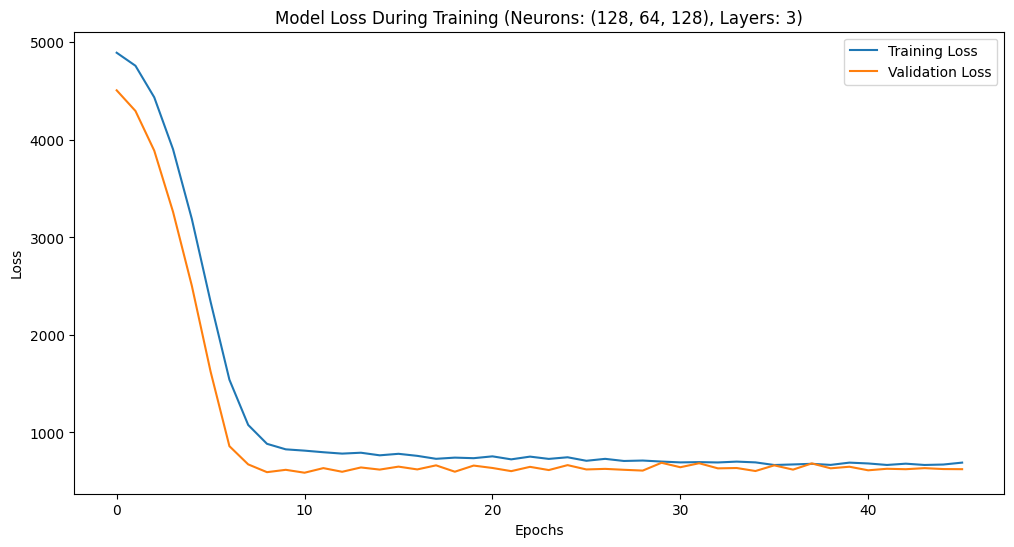

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
MAPE on the Training Data: 17.96%
MAPE für Brot: 20.47%
MAPE für Broetchen: 12.22%
MAPE für Croissant: 17.20%
MAPE für Konditorei: 22.93%
MAPE für Kuchen: 12.55%
MAPE für Saisonbrot: 46.55%

MAPE on the Validation Data: 20.92%
MAPE für Brot: 23.25%
MAPE für Broetchen: 12.85%
MAPE für Croissant: 20.74%
MAPE für Konditorei: 24.45%
MAPE für Kuchen: 17.20%
MAPE für Saisonbrot: 59.98%
Training with 3 layers and neurons (128, 64, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4879.5449 - mae: 207.6715 - val_loss: 4570.5112 - val_mae: 195.3075
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4851.5698 - mae: 206.5523 - val_loss: 4438.5864 - val_mae: 190.0254
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4683.6011 - mae: 199.8241 - val_loss: 4174.6929 - val_mae: 179.4545
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4431.2334 - mae: 189.7035 - val_loss: 3915.8865 - val_mae: 169.0621
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4122.6025 - mae: 177.2563 - val_loss: 3397.6528 - val_mae: 148.1757
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3681.2161 - mae: 159.4285 - val_loss: 2944.4182 - val_mae: 129.9844
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3248.3059 - mae: 141.9823 - val_loss: 2404.4124 - val_mae: 108.4531
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2637.0791 - mae: 117.5384 - val_loss: 1905.1587 

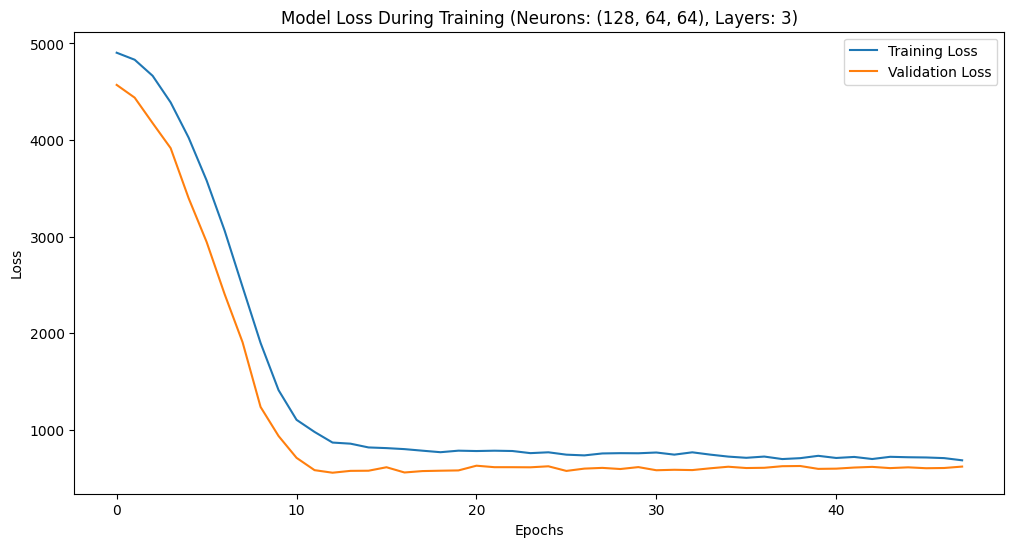

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
MAPE on the Training Data: 17.73%
MAPE für Brot: 18.90%
MAPE für Broetchen: 13.34%
MAPE für Croissant: 17.71%
MAPE für Konditorei: 21.04%
MAPE für Kuchen: 13.65%
MAPE für Saisonbrot: 43.38%

MAPE on the Validation Data: 18.82%
MAPE für Brot: 20.56%
MAPE für Broetchen: 11.86%
MAPE für Croissant: 18.70%
MAPE für Konditorei: 22.85%
MAPE für Kuchen: 15.11%
MAPE für Saisonbrot: 50.89%
Training with 3 layers and neurons (128, 64, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4862.4229 - mae: 206.9874

: 

In [7]:
# Wenn es eine gespeicherte Datei gibt, lade die Ergebnisse
try:
    with open('model_results.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []

# Funktion, um zu prüfen, ob ein Modell bereits getestet wurde
def is_model_tested(neurons_list, num_layers, results):
    for result in results:
        if result['neurons_list'] == neurons_list and result['num_layers'] == num_layers:
            return True
    return False

# Funktion zum Erstellen und Trainieren des Modells
def create_and_train_model(input_shape, neurons_list, num_layers, lr_schedule, loss, x_train, y_train, x_val, y_val):
    # Erstelle das Modell
    model = tf.keras.Sequential()
    
    # Erstelle die Schichten basierend auf der Anzahl der Schichten und Neuronen
    model.add(tf.keras.layers.Dense(neurons_list[0], activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)))
    for i in range(1, num_layers):
        model.add(tf.keras.layers.Dense(neurons_list[i], activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))  # Keine Aktivierungsfunktion im Output
    
    # Kompiliere das Modell
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=loss, metrics=['mae'])
    
    # Trainiere das Modell
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    return model, history

# Liste der verfügbaren Neuronenzahlen für jede Schicht
neurons_options = [128, 64, 32]

# Parameter
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.9
)
loss = Huber(delta=25)

# Modell für jede Kombination von Neuronenanzahl und Schichten trainieren
results = []

# Für jede Anzahl an Schichten (3 und 4 Schichten)
for num_layers in range(3, 5):  # Teste 3 und 4 Schichten
    # Für jede Kombination von Neuronenanzahl (z.B. [16], [32, 32], etc.)
    for neurons_list in itertools.product(neurons_options, repeat=num_layers):
        if is_model_tested(neurons_list, num_layers, results):
            print(f"Skipping {num_layers} layers with neurons {neurons_list} (already tested).")
            continue
        print(f"Training with {len(neurons_list)} layers and neurons {neurons_list}...")
        
        model, history = create_and_train_model(
            input_shape=len(features), 
            neurons_list=neurons_list, 
            num_layers=num_layers, 
            lr_schedule=lr_schedule, 
            loss=loss, 
            x_train=x_train, 
            y_train=y_train, 
            x_val=x_val, 
            y_val=y_val
        )
        
        # Visualisiere den Trainingsverlauf
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss During Training (Neurons: {neurons_list}, Layers: {num_layers})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Berechne Vorhersagen für Training und Validierung
        training_predictions = model.predict(x_train)
        validation_predictions = model.predict(x_val)

        # DataFrames für Vorhersagen
        train_predictions_df = pd.DataFrame({
            'Datum': train_data['Datum'],
            'id': train_data['id'],
            'Tatsächlicher Umsatz': y_train,
            'Vorhergesagter Umsatz': training_predictions.flatten()
        })
        
        val_predictions_df = pd.DataFrame({
            'Datum': val_data['Datum'],
            'id': val_data['id'],
            'Tatsächlicher Umsatz': y_val,
            'Vorhergesagter Umsatz': validation_predictions.flatten()
        })

        # Mapping für Warengruppen
        ware_mapping = {
            1: 'Brot',
            2: 'Broetchen',
            3: 'Croissant',
            4: 'Konditorei',
            5: 'Kuchen',
            6: 'Saisonbrot'
        }

        # MAPE berechnen
        train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

        val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year

        def calculate_mape(y_true, y_pred):
            non_zero_mask = y_true != 0
            return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        
        # calc total mape
        train_mape = calculate_mape(train_predictions_df['Tatsächlicher Umsatz'], train_predictions_df['Vorhergesagter Umsatz'])
        val_mape = calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz'])

        # Speichere das Modell, den Verlauf der Verluste und MAPE-Werte
        results.append({
            'neurons_list': neurons_list,
            'num_layers': num_layers,
            'history': history,
            'model': model,
            'train_mape': train_mape,
            'val_mape': val_mape
        })

        # Speichere die Ergebnisse nach jeder Iteration
        with open('model_results.pkl', 'wb') as f:
            pickle.dump(results, f)

        print(f"MAPE on the Training Data: {train_mape:.2f}%")
        for group in train_predictions_df['Warengruppe'].unique():
            group_data = train_predictions_df[train_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

        print(f"\nMAPE on the Validation Data: {val_mape:.2f}%")
        for group in val_predictions_df['Warengruppe'].unique():
            group_data = val_predictions_df[val_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

# Finde das beste Modell anhand des MAPE der Validierungsdaten
best_model = min(results, key=lambda x: calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz']))
print(f"Best Model: {best_model['neurons_list']} neurons, {best_model['num_layers']} layers")

## 4. Versuch: Noch einmal 4 Layers, die erste Layer hat die meisten Neuronen
Vielversprechend sind:

128 - 128 - 64 - 32

128 - 128 - 64 - 16

128 - 128 -32 - 64

Allerdings muss man bei 4 Layers aufpassen, da die Trainingsdaten schneller overfitted werden (Mape ~15 %). Der Mape für die Validierungsdaten liegt weiter um die 19 %.

2025-01-07 16:08:45.500125: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training with 4 layers and neurons (128, 128, 128, 128)...


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4887.6680 - mae: 207.9871 - val_loss: 4544.7427 - val_mae: 194.2673
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4733.9385 - mae: 201.8340 - val_loss: 4302.1748 - val_mae: 184.5561
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4557.6509 - mae: 194.7574 - val_loss: 3768.1565 - val_mae: 163.1278
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4038.7986 - mae: 173.8799 - val_loss: 3068.1519 - val_mae: 134.7654
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3358.5984 - mae: 146.4167 - val_loss: 2170.6987 - val_mae: 98.9823
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2497.9448 - mae: 111.9942 - val_loss: 1369.7384 - val_mae: 66.4470
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1694.0577 - mae: 79.2395 - val_loss: 902.7964 - val_mae: 47.2292
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1149.6840 - mae: 56.8643 - val_loss: 625.

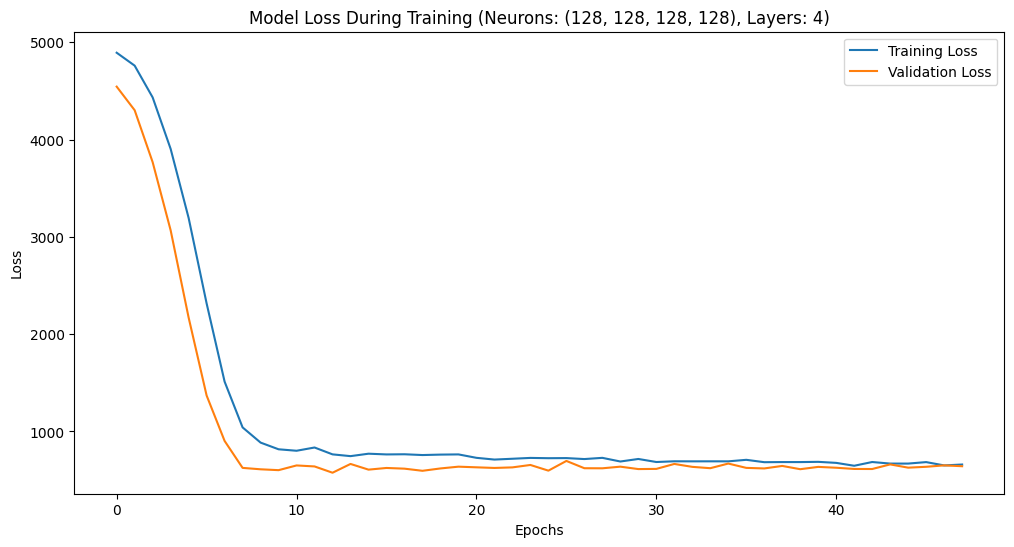

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 16.43%
MAPE für Brot: 17.81%
MAPE für Broetchen: 11.81%
MAPE für Croissant: 16.50%
MAPE für Konditorei: 19.75%
MAPE für Kuchen: 12.39%
MAPE für Saisonbrot: 41.32%

MAPE on the Validation Data: 19.16%
MAPE für Brot: 20.42%
MAPE für Broetchen: 13.30%
MAPE für Croissant: 20.32%
MAPE für Konditorei: 22.21%
MAPE für Kuchen: 15.71%
MAPE für Saisonbrot: 43.63%
Training with 4 layers and neurons (128, 128, 128, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4939.0850 - mae: 210.0453 - val_loss: 4548.5923 - val_mae: 194.4227
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4772.2603 - mae: 203.3707 - val_loss: 4432.0571 - val_mae: 189.7574
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4715.9312 - mae: 201.1117 - val_loss: 4212.3438 - val_mae: 180.9609
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4481.1069 - mae: 191.6924 - val_loss: 3916.5867 - val_mae: 169.0885
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4103.5967 - mae: 176.5013 - val_loss: 3452.3179 - val_mae: 150.3821
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3646.3748 - mae: 158.0852 - val_loss: 3064.8613 - val_mae: 134.8787
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3250.7534 - mae: 142.1817 - val_loss: 2472.5605 - val_mae: 111.2284
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2706.7297 - mae: 120.3538 - val_loss: 1880.7045 

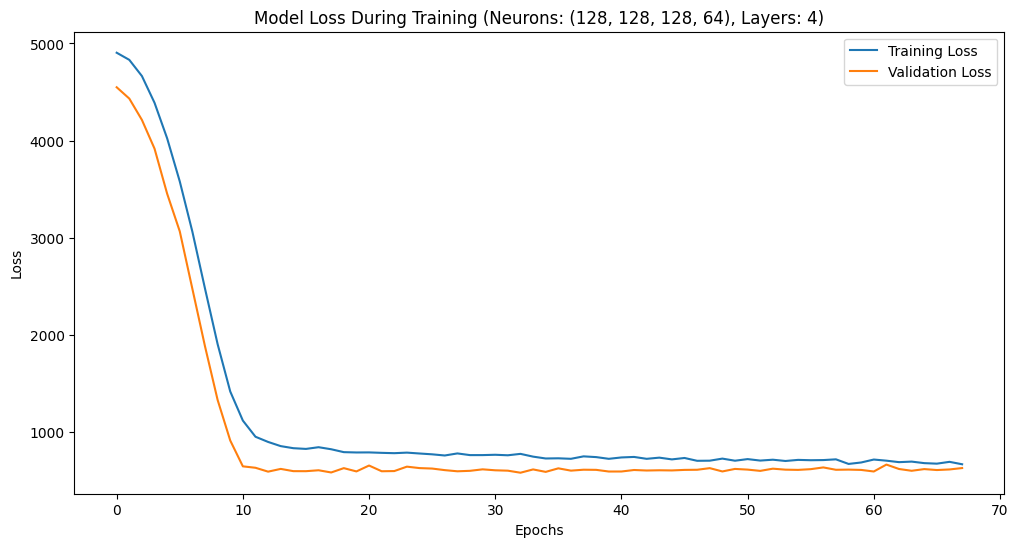

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 15.51%
MAPE für Brot: 16.81%
MAPE für Broetchen: 9.99%
MAPE für Croissant: 15.17%
MAPE für Konditorei: 19.77%
MAPE für Kuchen: 10.70%
MAPE für Saisonbrot: 48.03%

MAPE on the Validation Data: 20.31%
MAPE für Brot: 20.62%
MAPE für Broetchen: 13.21%
MAPE für Croissant: 22.85%
MAPE für Konditorei: 23.18%
MAPE für Kuchen: 16.06%
MAPE für Saisonbrot: 55.99%
Training with 4 layers and neurons (128, 128, 128, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5018.0557 - mae: 213.2062 - val_loss: 4567.0889 - val_mae: 195.1646
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4957.8320 - mae: 210.7959 - val_loss: 4503.8687 - val_mae: 192.6339
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4794.6196 - mae: 204.2668 - val_loss: 4362.8857 - val_mae: 186.9887
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4732.8208 - mae: 201.7840 - val_loss: 4195.6108 - val_mae: 180.2883
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4489.7744 - mae: 192.0412 - val_loss: 3970.0752 - val_mae: 171.2456
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4250.3823 - mae: 182.4365 - val_loss: 3702.6201 - val_mae: 160.4919
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4058.0583 - mae: 174.6805 - val_loss: 3448.8894 - val_mae: 150.3122
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3782.7993 - mae: 163.5809 - val_loss: 3187.7378 

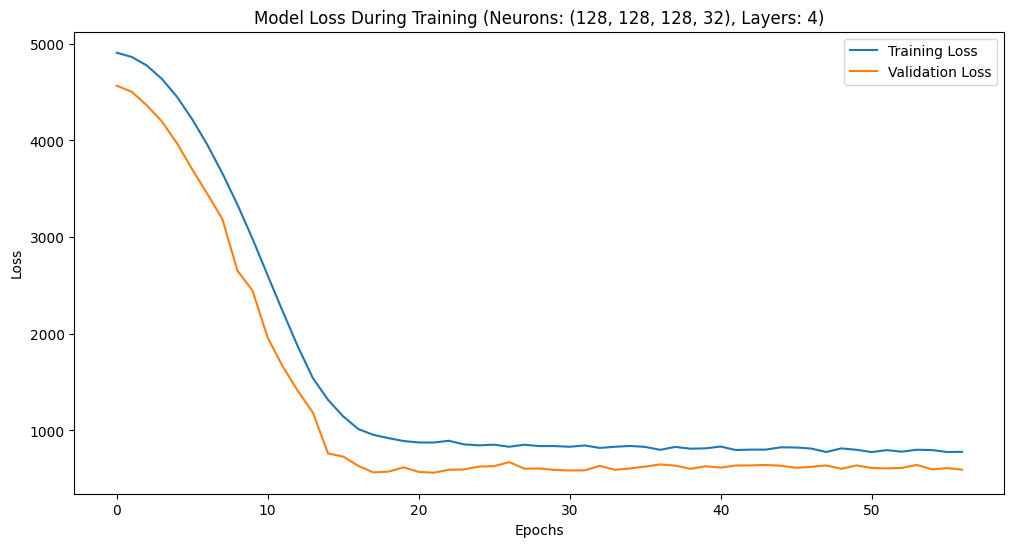

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 16.62%
MAPE für Brot: 17.22%
MAPE für Broetchen: 12.39%
MAPE für Croissant: 16.78%
MAPE für Konditorei: 20.32%
MAPE für Kuchen: 12.59%
MAPE für Saisonbrot: 41.10%

MAPE on the Validation Data: 19.12%
MAPE für Brot: 19.62%
MAPE für Broetchen: 12.78%
MAPE für Croissant: 19.80%
MAPE für Konditorei: 23.74%
MAPE für Kuchen: 15.82%
MAPE für Saisonbrot: 43.75%
Training with 4 layers and neurons (128, 128, 128, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4885.4507 - mae: 207.9032 - val_loss: 4576.2017 - val_mae: 195.5301
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4943.8013 - mae: 210.2368 - val_loss: 4536.8535 - val_mae: 193.9549
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4890.8750 - mae: 208.1175 - val_loss: 4475.3857 - val_mae: 191.4950
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4714.1045 - mae: 201.0474 - val_loss: 4393.5786 - val_mae: 188.2194
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4689.6001 - mae: 200.0601 - val_loss: 4264.0234 - val_mae: 183.0316
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4641.3047 - mae: 198.1172 - val_loss: 4119.3745 - val_mae: 177.2380
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4461.0259 - mae: 190.8942 - val_loss: 3996.3123 - val_mae: 172.3015
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4306.1440 - mae: 184.6777 - val_loss: 3821.2991 

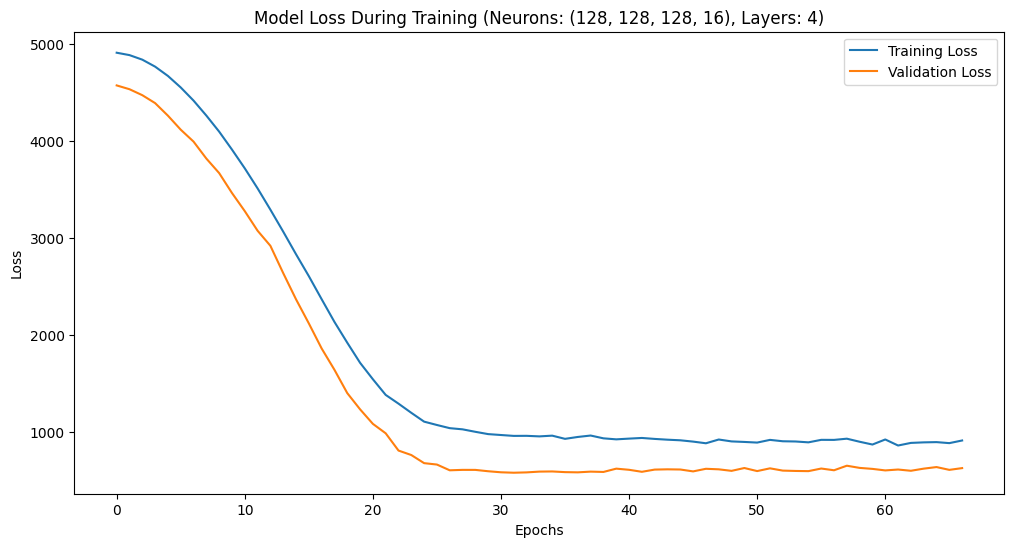

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 16.34%
MAPE für Brot: 17.30%
MAPE für Broetchen: 12.38%
MAPE für Croissant: 16.11%
MAPE für Konditorei: 19.09%
MAPE für Kuchen: 12.17%
MAPE für Saisonbrot: 45.80%

MAPE on the Validation Data: 19.52%
MAPE für Brot: 20.60%
MAPE für Broetchen: 12.28%
MAPE für Croissant: 20.61%
MAPE für Konditorei: 23.26%
MAPE für Kuchen: 15.97%
MAPE für Saisonbrot: 50.79%
Training with 4 layers and neurons (128, 128, 64, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4989.7764 - mae: 212.0743 - val_loss: 4476.0454 - val_mae: 191.5198
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4907.0581 - mae: 208.7620 - val_loss: 4277.5913 - val_mae: 183.5731
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4587.2549 - mae: 195.9508 - val_loss: 3897.9292 - val_mae: 168.3342
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4139.6646 - mae: 177.9008 - val_loss: 3314.0388 - val_mae: 144.7941
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3417.5884 - mae: 148.7003 - val_loss: 2493.0364 - val_mae: 111.9716
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2592.6150 - mae: 115.6271 - val_loss: 1493.4420 - val_mae: 71.5315
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1788.6594 - mae: 83.0812 - val_loss: 942.6680 - val_mae: 48.5259
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1207.6770 - mae: 59.2397 - val_loss: 619.9931 - val_

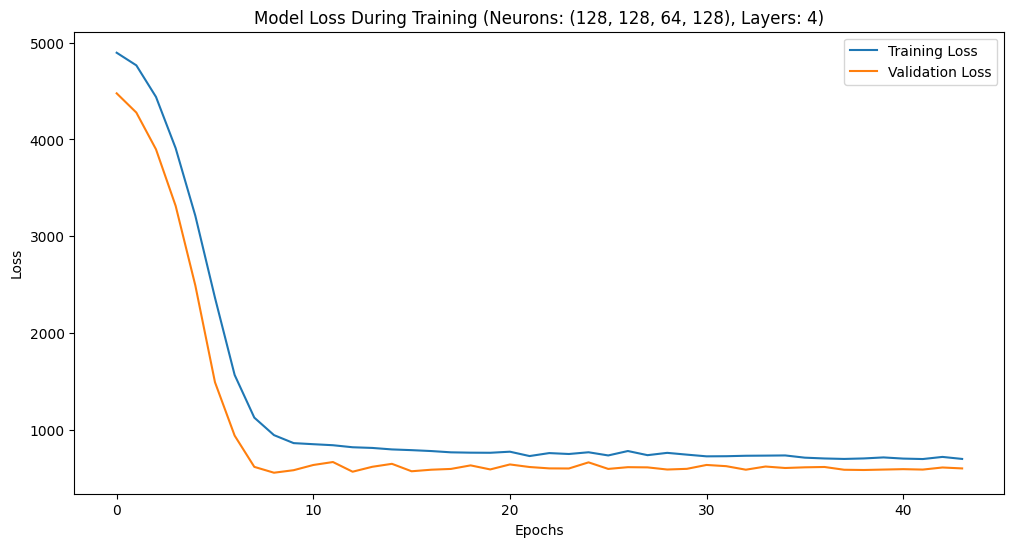

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 18.87%
MAPE für Brot: 20.21%
MAPE für Broetchen: 13.52%
MAPE für Croissant: 18.26%
MAPE für Konditorei: 24.97%
MAPE für Kuchen: 13.24%
MAPE für Saisonbrot: 45.96%

MAPE on the Validation Data: 19.26%
MAPE für Brot: 20.50%
MAPE für Broetchen: 13.97%
MAPE für Croissant: 18.58%
MAPE für Konditorei: 23.45%
MAPE für Kuchen: 14.90%
MAPE für Saisonbrot: 50.60%
Training with 4 layers and neurons (128, 128, 64, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4957.1606 - mae: 210.7710 - val_loss: 4540.5088 - val_mae: 194.1017
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4833.9019 - mae: 205.8411 - val_loss: 4442.5054 - val_mae: 190.1788
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4720.7412 - mae: 201.3058 - val_loss: 4231.5928 - val_mae: 181.7357
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4491.8706 - mae: 192.1201 - val_loss: 3859.9944 - val_mae: 166.8117
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4163.4399 - mae: 178.9151 - val_loss: 3491.1086 - val_mae: 151.9569
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3704.2124 - mae: 160.3778 - val_loss: 2976.6584 - val_mae: 131.3330
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3258.4849 - mae: 142.4375 - val_loss: 2291.8428 - val_mae: 103.8646
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2615.5886 - mae: 116.6456 - val_loss: 1515.2065 

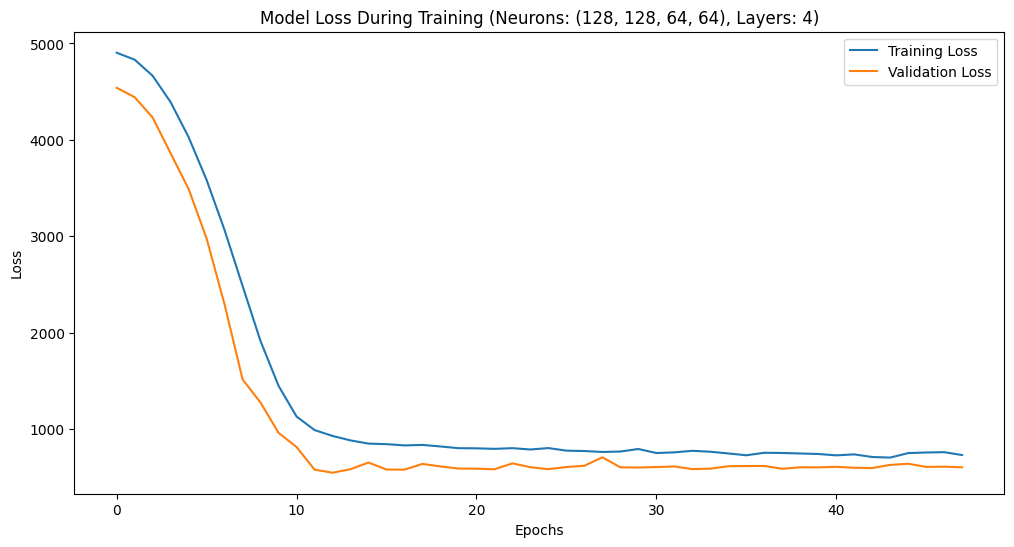

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 17.71%
MAPE für Brot: 18.90%
MAPE für Broetchen: 13.69%
MAPE für Croissant: 17.82%
MAPE für Konditorei: 20.70%
MAPE für Kuchen: 13.08%
MAPE für Saisonbrot: 45.37%

MAPE on the Validation Data: 19.07%
MAPE für Brot: 21.27%
MAPE für Broetchen: 12.73%
MAPE für Croissant: 18.59%
MAPE für Konditorei: 23.13%
MAPE für Kuchen: 15.21%
MAPE für Saisonbrot: 47.35%
Training with 4 layers and neurons (128, 128, 64, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4885.3999 - mae: 207.9023 - val_loss: 4558.8643 - val_mae: 194.8372
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4815.1621 - mae: 205.0912 - val_loss: 4506.9023 - val_mae: 192.7573
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4751.7437 - mae: 202.5495 - val_loss: 4397.5303 - val_mae: 188.3784
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4745.5029 - mae: 202.2939 - val_loss: 4234.5459 - val_mae: 181.8515
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4520.5552 - mae: 193.2776 - val_loss: 3990.4924 - val_mae: 172.0569
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4359.4551 - mae: 186.7990 - val_loss: 3707.2415 - val_mae: 160.6503
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4008.6438 - mae: 172.6844 - val_loss: 3411.4160 - val_mae: 148.7286
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3717.4680 - mae: 160.9294 - val_loss: 3145.4197 

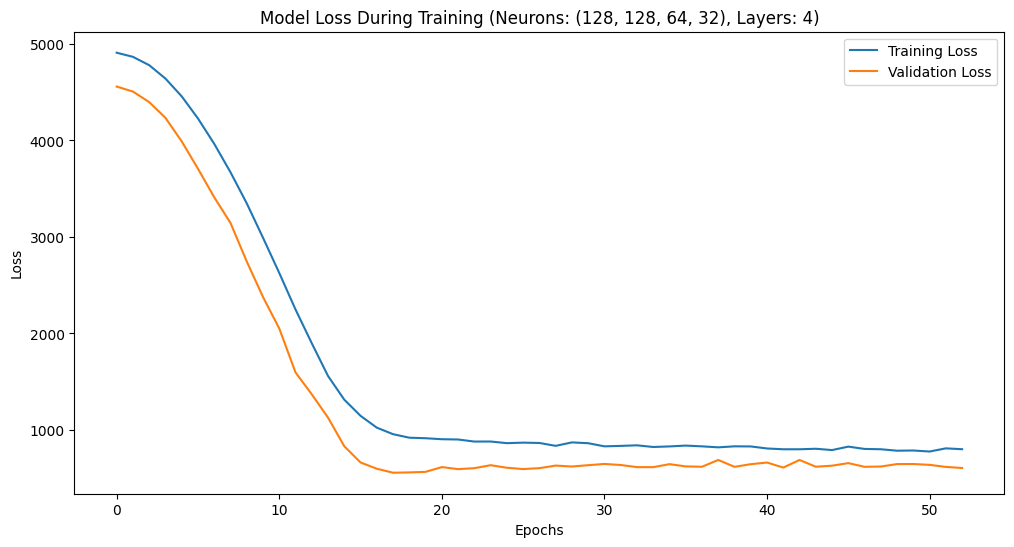

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MAPE on the Training Data: 17.34%
MAPE für Brot: 18.46%
MAPE für Broetchen: 14.16%
MAPE für Croissant: 16.91%
MAPE für Konditorei: 19.85%
MAPE für Kuchen: 13.23%
MAPE für Saisonbrot: 43.17%

MAPE on the Validation Data: 18.87%
MAPE für Brot: 20.77%
MAPE für Broetchen: 12.59%
MAPE für Croissant: 19.06%
MAPE für Konditorei: 23.65%
MAPE für Kuchen: 14.35%
MAPE für Saisonbrot: 43.88%
Training with 4 layers and neurons (128, 128, 64, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4936.5562 - mae: 209.9487 - val_loss: 4586.0415 - val_mae: 195.9255
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4889.3599 - mae: 208.0605 - val_loss: 4554.1675 - val_mae: 194.6501
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4859.7866 - mae: 206.8761 - val_loss: 4480.7822 - val_mae: 191.7133
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4815.4761 - mae: 205.1033 - val_loss: 4402.7520 - val_mae: 188.5908
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4630.6597 - mae: 197.7064 - val_loss: 4289.9150 - val_mae: 184.0741
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4542.2271 - mae: 194.1597 - val_loss: 4144.7539 - val_mae: 178.2550
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4414.7246 - mae: 189.0390 - val_loss: 4029.4412 - val_mae: 173.6346
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4306.1880 - mae: 184.6642 - val_loss: 3854.8569 

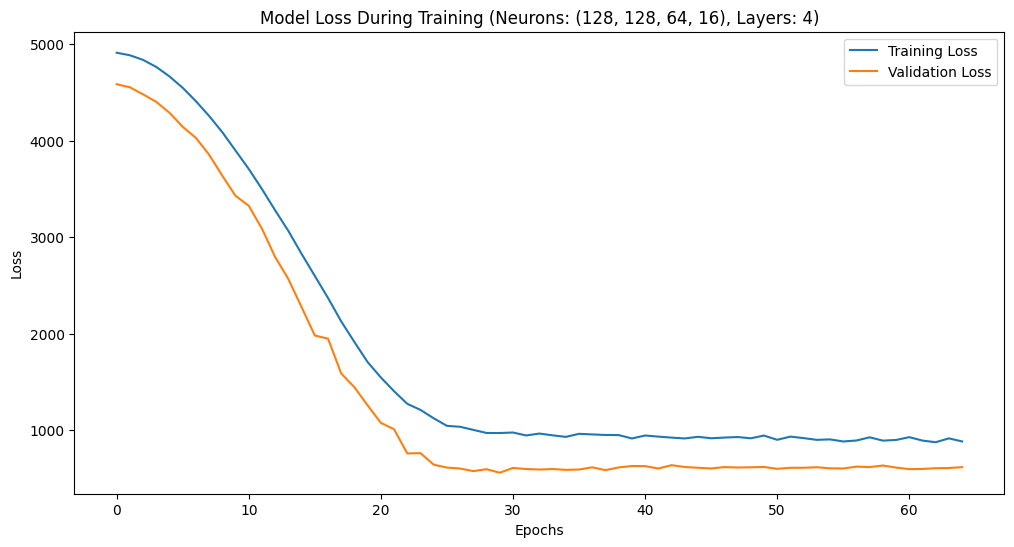

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
MAPE on the Training Data: 17.14%
MAPE für Brot: 17.59%
MAPE für Broetchen: 13.78%
MAPE für Croissant: 17.24%
MAPE für Konditorei: 19.78%
MAPE für Kuchen: 13.53%
MAPE für Saisonbrot: 41.19%

MAPE on the Validation Data: 18.75%
MAPE für Brot: 19.69%
MAPE für Broetchen: 11.91%
MAPE für Croissant: 20.86%
MAPE für Konditorei: 22.00%
MAPE für Kuchen: 14.87%
MAPE für Saisonbrot: 46.93%
Training with 4 layers and neurons (128, 128, 32, 128)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4814.4355 - mae: 205.0620 - val_loss: 4527.2935 - val_mae: 193.5745
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4769.0425 - mae: 203.2425 - val_loss: 4319.5527 - val_mae: 185.2594
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4531.6152 - mae: 193.7240 - val_loss: 3858.7053 - val_mae: 166.7593
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4104.1060 - mae: 176.4730 - val_loss: 3201.1086 - val_mae: 140.1041
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3373.0715 - mae: 146.8828 - val_loss: 2276.9229 - val_mae: 103.2028
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2557.0347 - mae: 114.1841 - val_loss: 1616.4097 - val_mae: 76.5553
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1803.2844 - mae: 83.6379 - val_loss: 941.7784 - val_mae: 48.4270
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1172.6770 - mae: 57.7846 - val_loss: 612.8449 - val_

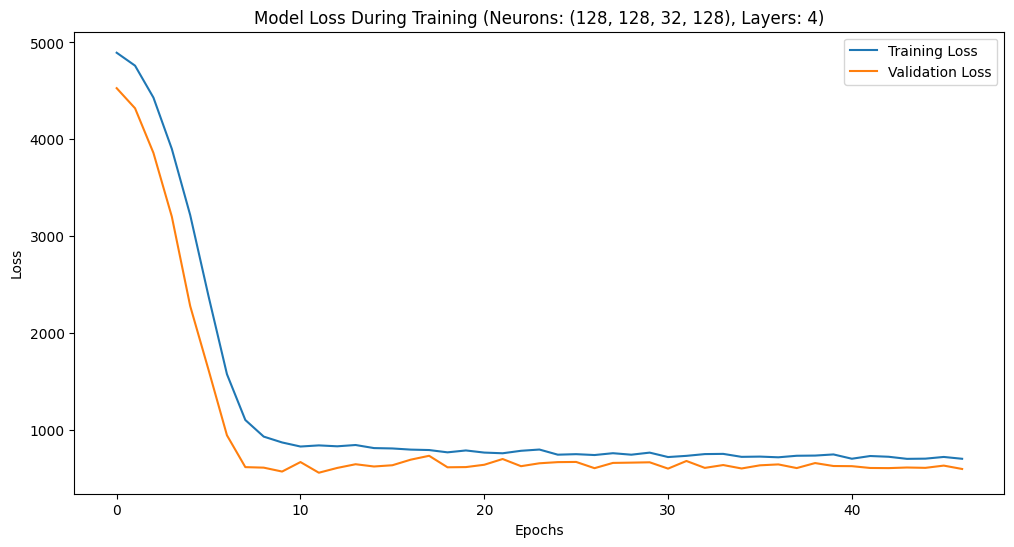

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 18.81%
MAPE für Brot: 20.98%
MAPE für Broetchen: 11.98%
MAPE für Croissant: 18.03%
MAPE für Konditorei: 24.07%
MAPE für Kuchen: 12.78%
MAPE für Saisonbrot: 58.34%

MAPE on the Validation Data: 20.33%
MAPE für Brot: 23.09%
MAPE für Broetchen: 12.38%
MAPE für Croissant: 21.04%
MAPE für Konditorei: 24.41%
MAPE für Kuchen: 14.74%
MAPE für Saisonbrot: 58.72%
Training with 4 layers and neurons (128, 128, 32, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4975.0239 - mae: 211.4882 - val_loss: 4560.7305 - val_mae: 194.9128
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4818.2026 - mae: 205.2146 - val_loss: 4451.7202 - val_mae: 190.5497
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4730.1060 - mae: 201.6808 - val_loss: 4215.3081 - val_mae: 181.0826
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4482.8457 - mae: 191.7581 - val_loss: 3884.0042 - val_mae: 167.7834
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4161.5566 - mae: 178.8182 - val_loss: 3479.2195 - val_mae: 151.4744
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3668.5359 - mae: 158.8923 - val_loss: 3007.7405 - val_mae: 132.5946
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3267.4478 - mae: 142.7931 - val_loss: 2326.4929 - val_mae: 105.3339
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2667.5376 - mae: 118.6706 - val_loss: 1781.2903 

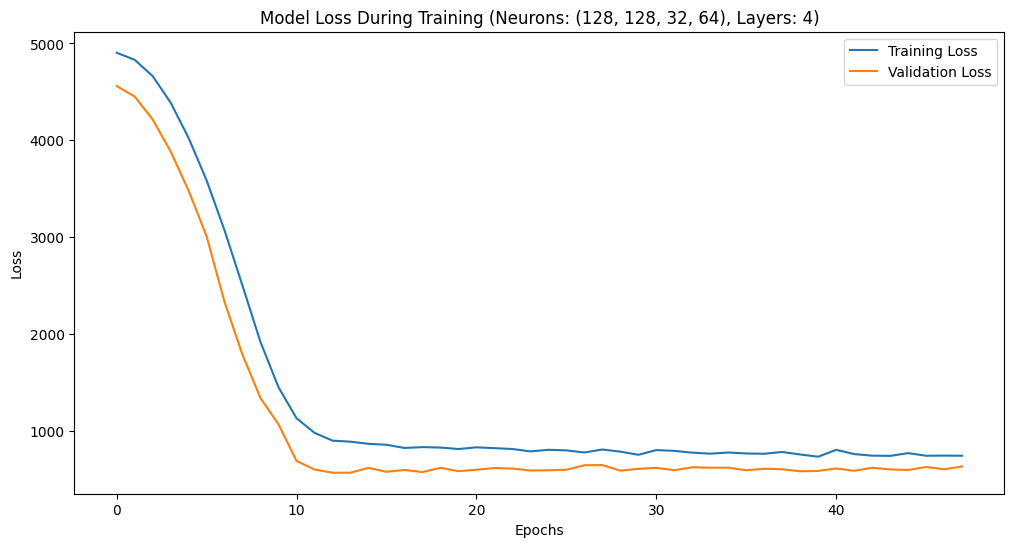

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 17.65%
MAPE für Brot: 18.71%
MAPE für Broetchen: 13.67%
MAPE für Croissant: 17.88%
MAPE für Konditorei: 21.17%
MAPE für Kuchen: 12.95%
MAPE für Saisonbrot: 42.24%

MAPE on the Validation Data: 18.93%
MAPE für Brot: 20.56%
MAPE für Broetchen: 12.61%
MAPE für Croissant: 19.33%
MAPE für Konditorei: 22.31%
MAPE für Kuchen: 15.70%
MAPE für Saisonbrot: 45.24%
Training with 4 layers and neurons (128, 128, 32, 32)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4917.7544 - mae: 209.1964 - val_loss: 4559.2139 - val_mae: 194.8531
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4935.3066 - mae: 209.8987 - val_loss: 4502.8906 - val_mae: 192.5995
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4799.1396 - mae: 204.4507 - val_loss: 4385.3750 - val_mae: 187.8979
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4774.9556 - mae: 203.4741 - val_loss: 4221.4839 - val_mae: 181.3338
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4411.4126 - mae: 188.9179 - val_loss: 4011.0623 - val_mae: 172.8916
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4242.0166 - mae: 182.1005 - val_loss: 3753.9373 - val_mae: 162.5338
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4036.2649 - mae: 173.7733 - val_loss: 3481.9922 - val_mae: 151.5552
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3762.3628 - mae: 162.6637 - val_loss: 3180.8215 

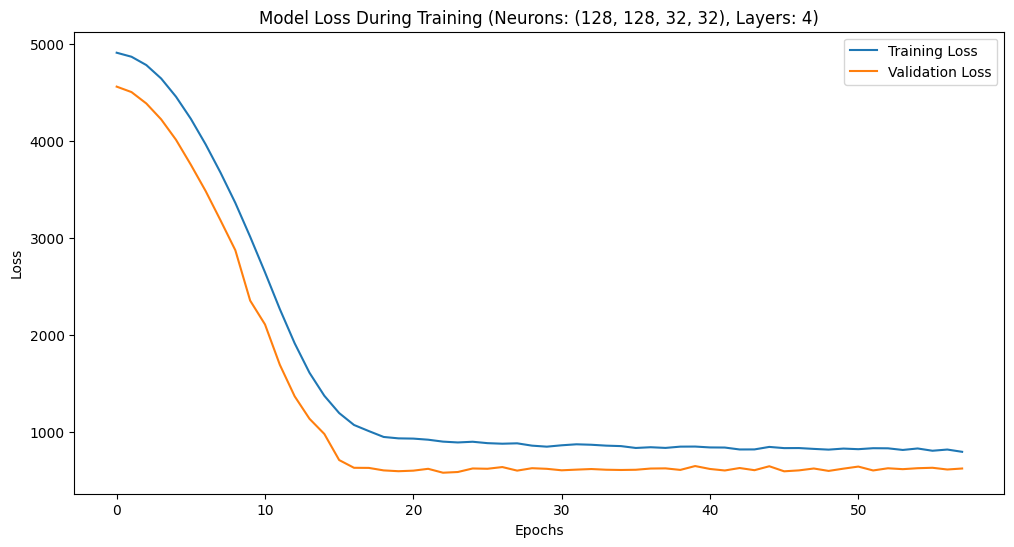

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 16.97%
MAPE für Brot: 19.18%
MAPE für Broetchen: 12.75%
MAPE für Croissant: 16.68%
MAPE für Konditorei: 20.18%
MAPE für Kuchen: 12.53%
MAPE für Saisonbrot: 39.68%

MAPE on the Validation Data: 20.28%
MAPE für Brot: 22.71%
MAPE für Broetchen: 12.79%
MAPE für Croissant: 21.03%
MAPE für Konditorei: 23.33%
MAPE für Kuchen: 16.88%
MAPE für Saisonbrot: 49.93%
Training with 4 layers and neurons (128, 128, 32, 16)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4967.7432 - mae: 211.1989 - val_loss: 4566.5264 - val_mae: 195.1462
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4900.6782 - mae: 208.5158 - val_loss: 4528.5469 - val_mae: 193.6270
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4844.9502 - mae: 206.2857 - val_loss: 4446.8740 - val_mae: 190.3579
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4741.8179 - mae: 202.1583 - val_loss: 4368.1445 - val_mae: 187.2057
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4672.1758 - mae: 199.3689 - val_loss: 4248.0469 - val_mae: 182.3952
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4578.4307 - mae: 195.6090 - val_loss: 4118.5371 - val_mae: 177.1950
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4465.1836 - mae: 191.0544 - val_loss: 3957.2222 - val_mae: 170.7101
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4319.5474 - mae: 185.2076 - val_loss: 3792.2056 

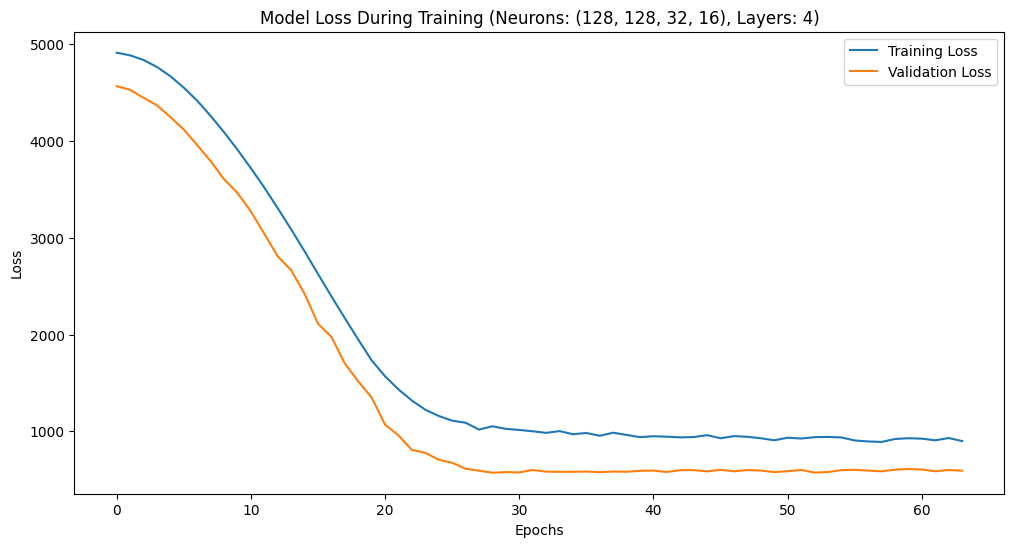

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 17.27%
MAPE für Brot: 18.20%
MAPE für Broetchen: 14.39%
MAPE für Croissant: 16.69%
MAPE für Konditorei: 20.07%
MAPE für Kuchen: 12.65%
MAPE für Saisonbrot: 44.71%

MAPE on the Validation Data: 19.13%
MAPE für Brot: 20.48%
MAPE für Broetchen: 13.12%
MAPE für Croissant: 19.61%
MAPE für Konditorei: 23.26%
MAPE für Kuchen: 14.55%
MAPE für Saisonbrot: 48.79%
Training with 4 layers and neurons (128, 128, 16, 128)...


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4859.7920 - mae: 206.8806 - val_loss: 4519.2144 - val_mae: 193.2534
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4811.7100 - mae: 204.9524 - val_loss: 4315.1387 - val_mae: 185.0839
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4614.9019 - mae: 197.0579 - val_loss: 3882.0532 - val_mae: 167.6907
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4086.5044 - mae: 175.7682 - val_loss: 3242.5710 - val_mae: 141.7367
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3431.0222 - mae: 149.1361 - val_loss: 2296.4468 - val_mae: 103.9029
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2639.0217 - mae: 117.4595 - val_loss: 1265.3894 - val_mae: 62.1539
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1707.4354 - mae: 79.7267 - val_loss: 846.0511 - val_mae: 44.4458
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1201.4115 - mae: 58.9624 - val_loss: 642

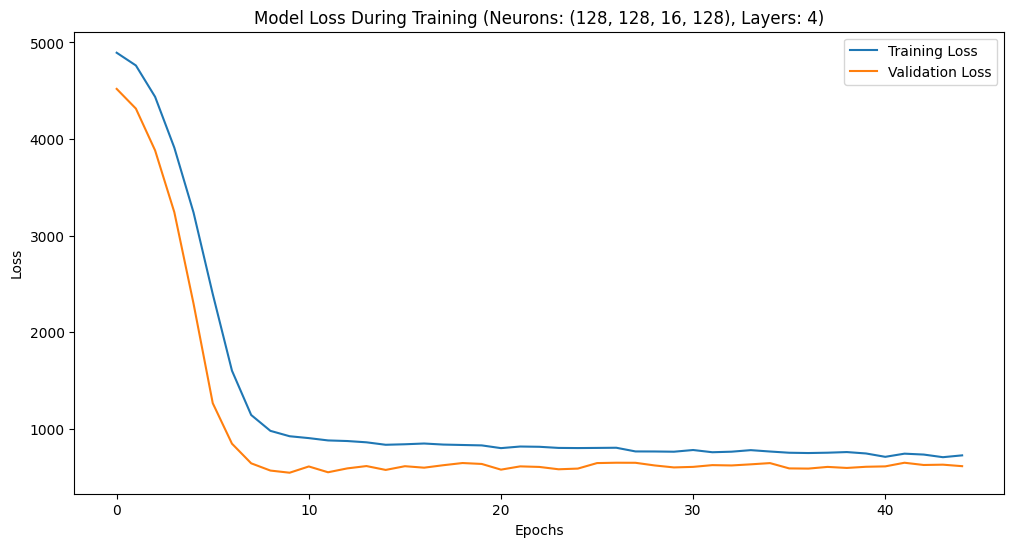

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 19.07%
MAPE für Brot: 20.49%
MAPE für Broetchen: 13.44%
MAPE für Croissant: 18.65%
MAPE für Konditorei: 24.08%
MAPE für Kuchen: 13.42%
MAPE für Saisonbrot: 52.90%

MAPE on the Validation Data: 19.36%
MAPE für Brot: 20.75%
MAPE für Broetchen: 13.79%
MAPE für Croissant: 19.09%
MAPE für Konditorei: 22.71%
MAPE für Kuchen: 15.27%
MAPE für Saisonbrot: 52.62%
Training with 4 layers and neurons (128, 128, 16, 64)...
Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4876.4160 - mae: 207.5458 - val_loss: 4542.6084 - val_mae: 194.1894
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4902.2593 - mae: 208.5759 - val_loss: 4421.5781 - val_mae: 189.3443
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4646.7383 - mae: 198.3481 - val_loss: 4201.3882 - val_mae: 180.5231
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4453.9932 - mae: 190.6109 - val_loss: 3901.7288 - val_mae: 168.4921
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4131.1597 - mae: 177.6129 - val_loss: 3480.7734 - val_mae: 151.4681
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3733.5703 - mae: 161.5269 - val_loss: 2838.4250 - val_mae: 125.5396
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3210.8596 - mae: 140.4507 - val_loss: 2287.2891 - val_mae: 103.5316
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2723.4653 - mae: 120.8582 - val_loss: 1725.6074 

: 

In [5]:
# Wenn es eine gespeicherte Datei gibt, lade die Ergebnisse
try:
    with open('model_results.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []

# Funktion, um zu prüfen, ob ein Modell bereits getestet wurde
def is_model_tested(neurons_list, num_layers, results):
    for result in results:
        if result['neurons_list'] == neurons_list and result['num_layers'] == num_layers:
            return True
    return False

# Funktion zum Erstellen und Trainieren des Modells
def create_and_train_model(input_shape, neurons_list, num_layers, lr_schedule, loss, x_train, y_train, x_val, y_val):
    # Erstelle das Modell
    model = tf.keras.Sequential()
    
    # Erstelle die Schichten basierend auf der Anzahl der Schichten und Neuronen
    model.add(tf.keras.layers.Dense(neurons_list[0], activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)))
    for i in range(1, num_layers):
        model.add(tf.keras.layers.Dense(neurons_list[i], activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))  # Keine Aktivierungsfunktion im Output
    
    # Kompiliere das Modell
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=loss, metrics=['mae'])
    
    # Trainiere das Modell
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    return model, history

# Liste der verfügbaren Neuronenzahlen für jede Schicht
neurons_options = [128, 64, 32, 16]

# Parameter
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.9
)
loss = Huber(delta=25)

# Modell für jede Kombination von Neuronenanzahl und Schichten trainieren
results = []

# Für jede Anzahl an Schichten (3 und 4 Schichten)
for num_layers in range(4, 5):  # Teste 3 und 4 Schichten
    # Für jede Kombination von Neuronenanzahl (z.B. [16], [32, 32], etc.)
    for neurons_list in itertools.product(neurons_options, repeat=num_layers):
        if is_model_tested(neurons_list, num_layers, results):
            print(f"Skipping {num_layers} layers with neurons {neurons_list} (already tested).")
            continue
        print(f"Training with {len(neurons_list)} layers and neurons {neurons_list}...")
        
        model, history = create_and_train_model(
            input_shape=len(features), 
            neurons_list=neurons_list, 
            num_layers=num_layers, 
            lr_schedule=lr_schedule, 
            loss=loss, 
            x_train=x_train, 
            y_train=y_train, 
            x_val=x_val, 
            y_val=y_val
        )
        
        # Visualisiere den Trainingsverlauf
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss During Training (Neurons: {neurons_list}, Layers: {num_layers})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Berechne Vorhersagen für Training und Validierung
        training_predictions = model.predict(x_train)
        validation_predictions = model.predict(x_val)

        # DataFrames für Vorhersagen
        train_predictions_df = pd.DataFrame({
            'Datum': train_data['Datum'],
            'id': train_data['id'],
            'Tatsächlicher Umsatz': y_train,
            'Vorhergesagter Umsatz': training_predictions.flatten()
        })
        
        val_predictions_df = pd.DataFrame({
            'Datum': val_data['Datum'],
            'id': val_data['id'],
            'Tatsächlicher Umsatz': y_val,
            'Vorhergesagter Umsatz': validation_predictions.flatten()
        })

        # Mapping für Warengruppen
        ware_mapping = {
            1: 'Brot',
            2: 'Broetchen',
            3: 'Croissant',
            4: 'Konditorei',
            5: 'Kuchen',
            6: 'Saisonbrot'
        }

        # MAPE berechnen
        train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

        val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
        val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
        val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year

        def calculate_mape(y_true, y_pred):
            non_zero_mask = y_true != 0
            return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        
        # calc total mape
        train_mape = calculate_mape(train_predictions_df['Tatsächlicher Umsatz'], train_predictions_df['Vorhergesagter Umsatz'])
        val_mape = calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz'])

        # Speichere das Modell, den Verlauf der Verluste und MAPE-Werte
        results.append({
            'neurons_list': neurons_list,
            'num_layers': num_layers,
            'history': history,
            'model': model,
            'train_mape': train_mape,
            'val_mape': val_mape
        })

        # Speichere die Ergebnisse nach jeder Iteration
        with open('model_results.pkl', 'wb') as f:
            pickle.dump(results, f)

        print(f"MAPE on the Training Data: {train_mape:.2f}%")
        for group in train_predictions_df['Warengruppe'].unique():
            group_data = train_predictions_df[train_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

        print(f"\nMAPE on the Validation Data: {val_mape:.2f}%")
        for group in val_predictions_df['Warengruppe'].unique():
            group_data = val_predictions_df[val_predictions_df['Warengruppe'] == group]
            mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
            print(f"MAPE für {group}: {mape:.2f}%")

# Finde das beste Modell anhand des MAPE der Validierungsdaten
best_model = min(results, key=lambda x: calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz']))
print(f"Best Model: {best_model['neurons_list']} neurons, {best_model['num_layers']} layers")